# Analýza věku a pohlaví podle pětiletých věkových skupin

### Import knihoven


In [1]:
import pandas as pd
import numpy as np
import pymongo
import utils.data_loader as data_loader
import pprint
import json
from cis import *

### Poznámky

In [2]:
# https://www.czso.cz/csu/rso/uzemne_technicke_jednotky
# https://scitani.gov.cz/vysledky
# https://www.czso.cz/csu/czso/vysledky-scitani-2021-otevrena-data

### Pomocné funkce

In [2]:
# Tisk čísla s oddělovači čárek
def format_with_commas(number):
    return "{:,}".format(number)

# Hezký tisk slovníku pro věk
def print_dictionary_ages(text, dict):
    print(f"{text}")
    for key, value in dict.items():
        print(f"\t=> {key}: {value} ({(value / analysis_result['count'])*100:.2f}%)")

# Hezký tisk slovníku pro věk a pohlaví
def print_dictionary_ages_sex(text, dict, total):
    print(f"{text}")
    for outer_key, outer_value in dict.items():
        print(f"\t=> {outer_key} ({(dict[outer_key]['total'] / total) * 100:.2f} %):")
        for key, value in outer_value.items():
            print(f"\t\t=> {key}: {value} ({(value / dict[outer_key]['total']) * 100:.2f} %)")

### Uložení CSV dat do MongoDB

In [3]:
data_loader.load_csv_into_db("vek_pohlavi_5", "../data_original/sldb2021_vek5_pohlavi.csv")

KeyboardInterrupt: 

### Načtení dat do paměti z MongoDB

In [28]:
data = data_loader.load_from_db("vzdelani_vek_pohlavi")

### Analýza

In [2]:
# Pomocné CIS kódy
cis_vek = {
    1100000004: '0 - 4 roky',
    1300050009: '5 - 9 let',
    1300100014: '10 - 14 let',
    1300150019: '15 - 19 let',
    1300200024: '20 - 24 let',
    1300250029: '25 - 29 let',
    1300300034: '30 - 34 let',
    1300350039: '35 - 39 let',
    1300400044: '40 - 44 let',
    1300450049: '45 - 49 let',
    1300500054: '50 - 54 let',
    1300550059: '55 - 59 let',
    1300600064: '60 - 64 let',
    1300650069: '65 - 69 let',
    1300700074: '70 - 74 let',
    1300750079: '75 - 79 let',
    1300800084: '80 - 84 let',
    1300850089: '85 - 89 let',
    1300900094: '90 - 94 let',
    1300950099: '95 - 99 let',
    1201009999: '100 a více let'
}

vek_txt = {
    '0 - 4 roky': 1,
    '5 - 9 let': 2,
    '10 - 14 let': 3,
    '15 - 19 let': 4,
    '20 - 24 let': 5,
    '25 - 29 let': 6,
    '30 - 34 let': 7,
    '35 - 39 let': 8,
    '40 - 44 let': 9,
    '45 - 49 let': 10,
    '50 - 54 let': 11,
    '55 - 59 let': 12,
    '60 - 64 let': 13,
    '65 - 69 let': 14,
    '70 - 74 let': 15,
    '75 - 79 let': 16,
    '80 - 84 let': 17,
    '85 - 89 let': 18,
    '90 - 94 let': 19,
    '95 - 99 let': 20,
    '100 a více let': 21 
}

vzdelani_txt = {
    'Bez vzdělání': 1,
    'Neúplné základní vzdělání': 2,
    'Základní vzdělání': 3,
    'Úplné střední všeobecné vzdělání': 8,
    'Vyšší odborné vzdělání': 11,
    'Vysokoškolské bakalářské vzdělání': 12,
    'Vysokoškolské magisterské vzdělání': 13,
    'Vysokoškolské doktorské vzdělání': 14,
    'Vyšší odborné vzdělání v konzervatoři': 15,
    'Nižší střední a střední vzdělání': 105,
    'Úplné střední odborné vzdělání': 121,
    'Nástavbové vzdělání': 202,
    'Pomaturitní studium': 203,
    'Nezjištěno': 900
}

cis_kraje = {
    3026: 'Středočeský kraj',
    3018: 'Hlavní město Praha',
    3115: 'Jihomoravský kraj',
    3140: 'Moravskoslezský kraj',
    3069: 'Ústecký kraj',
    3034: 'Jihočeský kraj',
    3123: 'Olomoucký kraj',
    3042: 'Plzeňský kraj',
    3131: 'Zlínský kraj',
    3085: 'Královéhradecký kraj',
    3093: 'Pardubický kraj',
    3107: 'Kraj Vysočina',
    3077: 'Liberecký kraj',
    3051: 'Karlovarský kraj'
}

veky_podle_fazi = {
    'deti': ['0 - 4 roky', '5 - 9 let'],
    'dospivani': ['10 - 14 let','15 - 19 let'],
    'dospeli': ['20 - 24 let', '25 - 29 let', '30 - 34 let', '35 - 39 let', '40 - 44 let', '45 - 49 let', '50 - 54 let', '55 - 59 let'],
    'stari': ['60 - 64 let', '65 - 69 let', '70 - 74 let', '75 - 79 let', '80 - 84 let', '85 - 89 let', '90 - 94 let', '95 - 99 let', '100 a více let'],
}

In [12]:
analysis_result = dict()

# Celkový počet obyvatel
analysis_result['count'] = int(data[(data['uzemi_cis'] == 97) & (data['vek_txt'].isnull()) & (data['pohlavi_txt'].isnull())]['hodnota'])

# Celkový počet obyvatel podle pohlaví
analysis_result['count_women'] = int(data[(data['uzemi_cis'] == 97) & (data['vek_txt'].isnull()) & (data['pohlavi_kod'] == 2)]['hodnota'])
analysis_result['count_men'] = int(data[(data['uzemi_cis'] == 97) & (data['vek_txt'].isnull()) & (data['pohlavi_kod'] == 1)]['hodnota'])

# Celkový počet obyvatel podle věku
analysis_result['count_ages'] = {}
for key, value in cis_vek.items():
    analysis_result['count_ages'][value] = int(data[(data['uzemi_cis'] == 97) & (data['vek_kod'] == key) & (data['pohlavi_txt'].isnull())]['hodnota'])

# Celkový počet obyvatel podle věku a pohlaví
analysis_result['count_age_sex'] = {}
for key, value in cis_vek.items():
    analysis_result['count_age_sex'][value] = {}
    analysis_result['count_age_sex'][value]['women'] = int(data[(data['uzemi_cis'] == 97) & (data['vek_kod'] == key) & (data['pohlavi_kod'] == 2)]['hodnota'])
    analysis_result['count_age_sex'][value]['men'] = int(data[(data['uzemi_cis'] == 97) & (data['vek_kod'] == key) & (data['pohlavi_kod'] == 1)]['hodnota'])

# Celkový počet obyvatel podle věkových fází (období)
analysis_result['count_age_phase'] = {}
for key, value in veky_podle_fazi.items():
    analysis_result['count_age_phase'][key] = 0
    for phase in value:
        analysis_result['count_age_phase'][key] += int(data[(data['uzemi_cis'] == 97) & (data['vek_txt'] == phase) & (data['pohlavi_txt'].isnull())]['hodnota'])

# Celkový počet obyvatel podle věkových fází (období) a pohlaví
analysis_result['count_age_phase_sex'] = {}
for key, value in veky_podle_fazi.items():
    analysis_result['count_age_phase_sex'][key] = {}
    analysis_result['count_age_phase_sex'][key]['women'] = 0
    analysis_result['count_age_phase_sex'][key]['men'] = 0
    for phase in value:
        analysis_result['count_age_phase_sex'][key]['women'] += int(data[(data['uzemi_cis'] == 97) & (data['vek_txt'] == phase) & (data['pohlavi_kod'] == 2)]['hodnota'])
        analysis_result['count_age_phase_sex'][key]['men'] += int(data[(data['uzemi_cis'] == 97) & (data['vek_txt'] == phase) & (data['pohlavi_kod'] == 1)]['hodnota'])

# Celkový počet obyvatel podle okresu, věku a pohlaví
analysis_result['count_sex_district'] = {}
for key, value in cis_okresy.items():
    key_int = int(key)
    analysis_result['count_sex_district'][key_int] = {}
    analysis_result['count_sex_district'][key_int]['name'] = value
    analysis_result['count_sex_district'][key_int]['data'] = {}
    analysis_result['count_sex_district'][key_int]['data']['women'] = []
    analysis_result['count_sex_district'][key_int]['data']['men'] = []
    for key2, value2 in cis_vek.items(): 
        analysis_result['count_sex_district'][key_int]['data']['women'].append(int(data[(data['uzemi_kod'] == key_int) & (data['uzemi_cis'] == 101) & (data['pohlavi_kod'] == 2) & (data['vek_txt'] == value2)]['hodnota']))
        analysis_result['count_sex_district'][key_int]['data']['men'].append(int(data[(data['uzemi_kod'] == key_int) & (data['uzemi_cis'] == 101) & (data['pohlavi_kod'] == 1) & (data['vek_txt'] == value2)]['hodnota']))

# Výsledky analýzy

In [13]:
# Celkový počet obyvatel
print(f"Celkový počet obyvatel: {format_with_commas(analysis_result['count'])}")
print(f"\nCelkový počet žen: {format_with_commas(analysis_result['count_women'])} ({(analysis_result['count_women'] / analysis_result['count'])*100:.2f}%)")
print(f"\nCelkový počet muž: {format_with_commas(analysis_result['count_men'])} ({(analysis_result['count_men'] / analysis_result['count'])*100:.2f}%)")
print_dictionary_ages("\nCelkový počet obyvatel podle věku:", analysis_result['count_ages'])
print_dictionary_ages_sex("\nCelkový počet obyvatel podle věku a pohlaví:", analysis_result['count_age_sex'])
print_dictionary_ages("\nCelkový počet obyvatel podle věkoých fází:", analysis_result['count_age_phase'])
print_dictionary_ages_sex("\nCelkový počet obyvatel podle věkových fází a pohlaví:", analysis_result['count_age_phase_sex'])
# print_dictionary_ages_sex("\nCelkový počet obyvatel podle pohlaví a kraje:", analysis_result['count_sex_district'])
# pprint.pprint(analysis_result['count_sex_district'])
# output = json.dumps(analysis_result['count_sex_district'], ensure_ascii=False).encode('utf8')
# with open('output.json', 'w') as f:
#     f.write(output.decode())

Celkový počet obyvatel: 10,524,167

Celkový počet žen: 5,337,619 (50.72%)

Celkový počet muž: 5,186,548 (49.28%)

Celkový počet obyvatel podle věku:
	=> 0 - 4 roky: 560632 (5.33%)
	=> 5 - 9 let: 550024 (5.23%)
	=> 10 - 14 let: 581104 (5.52%)
	=> 15 - 19 let: 489836 (4.65%)
	=> 20 - 24 let: 477063 (4.53%)
	=> 25 - 29 let: 601168 (5.71%)
	=> 30 - 34 let: 690561 (6.56%)
	=> 35 - 39 let: 719089 (6.83%)
	=> 40 - 44 let: 857917 (8.15%)
	=> 45 - 49 let: 877616 (8.34%)
	=> 50 - 54 let: 688110 (6.54%)
	=> 55 - 59 let: 666391 (6.33%)
	=> 60 - 64 let: 616608 (5.86%)
	=> 65 - 69 let: 668081 (6.35%)
	=> 70 - 74 let: 618629 (5.88%)
	=> 75 - 79 let: 419368 (3.98%)
	=> 80 - 84 let: 243373 (2.31%)
	=> 85 - 89 let: 135311 (1.29%)
	=> 90 - 94 let: 52786 (0.50%)
	=> 95 - 99 let: 9853 (0.09%)
	=> 100 a více let: 647 (0.01%)

Celkový počet obyvatel podle věku a pohlaví:
	=> 0 - 4 roky:
		=> women: 273743
		=> men: 286889
	=> 5 - 9 let:
		=> women: 267952
		=> men: 282072
	=> 10 - 14 let:
		=> women: 283743


In [30]:
import pandas as pd

data_path = '../data_original/sldb2021_vek5_pohlavi.csv'
data = pd.read_csv(data_path)
data_filtered = data[data['vek_txt'].notna() & data['pohlavi_txt'].isna()]
data_filtered = data_filtered.loc[data_filtered['uzemi_cis'] == 97]
data_filtered['vek_txt_ciselny'] = data_filtered['vek_txt'].map(vek_txt)
data_filtered.head()


,idhod,hodnota,ukaz_kod,vek_cis,vek_kod,pohlavi_cis,pohlavi_kod,uzemi_cis,uzemi_kod,sldb_rok,sldb_datum,ukaz_txt,vek_txt,pohlavi_txt,uzemi_txt,vek_txt_ciselny
437187,964588155,560632,3162,1035.0,1.100000e+09,NaN,NaN,97,19,2021,2021-03-26,Počet obyvatel s obvyklým pobytem,0 - 4 roky,NaN,Česká republika,0
437190,964588148,550024,3162,1035.0,1.300050e+09,NaN,NaN,97,19,2021,2021-03-26,Počet obyvatel s obvyklým pobytem,5 - 9 let,NaN,Česká republika,1
437193,964588730,581104,3162,1035.0,1.300100e+09,NaN,NaN,97,19,2021,2021-03-26,Počet obyvatel s obvyklým pobytem,10 - 14 let,NaN,Česká republika,2
437196,964588147,489836,3162,1035.0,1.300150e+09,NaN,NaN,97,19,2021,2021-03-26,Počet obyvatel s obvyklým pobytem,15 - 19 let,NaN,Česká republika,3
437199,964588146,477063,3162,1035.0,1.300200e+09,NaN,NaN,97,19,2021,2021-03-26,Počet obyvatel s obvyklým pobytem,20 - 24 let,NaN,Česká republika,4


In [27]:
# Definování věkových skupin a jejich počtů
age_groups = {
    "0 - 4 roky": 560632,
    "5 - 9 let": 550024,
    "10 - 14 let": 581104,
    "15 - 19 let": 489836,
    "20 - 24 let": 477063,
    "25 - 29 let": 601168,
    "30 - 34 let": 690561,
    "35 - 39 let": 719089,
    "40 - 44 let": 857917,
    "45 - 49 let": 877616,
    "50 - 54 let": 688110,
    "55 - 59 let": 666391,
    "60 - 64 let": 616608,
    "65 - 69 let": 668081,
    "70 - 74 let": 618629,
    "75 - 79 let": 419368,
    "80 - 84 let": 243373,
    "85 - 89 let": 135311,
    "90 - 94 let": 52786,
    "95 - 99 let": 9853,
    "100 a více let": 647,
}

# Oprava extrakce minimálního a maximálního věku
weighted_age_sum_corrected = 0

# Upravení logiky pro extrakci čísel z řetězce
for age_range, count in age_groups.items():
    if age_range == "100 a více let":
        representative_age = 102  # Speciální případ pro "100 a více let"
    else:
        # Upravení pro extrakci číselného rozsahu z řetězců
        min_age, max_age = [int(x) for x in age_range.replace(' let', '').replace(' roky', '').split(' - ')]
        representative_age = (min_age + max_age) / 2
    
    weighted_age_sum_corrected += representative_age * count

average_age_corrected = weighted_age_sum_corrected / 10524167
average_age_corrected


42.20571271816572

In [62]:
# Poměr mezi muži a ženy v obcích

import json

f = open('data/obce_kod_nazev.json')
obce_kod_nazev = json.load(f)['obce_kod_nazev']

f = open('data/obce_kod_pocet.json')
obce_kod_pocet = json.load(f)['obce_kod_pocet']

data_filtered_obce = data[data['vek_txt'].isna() & data['pohlavi_txt'].notna()]
data_filtered_obce = data_filtered_obce.loc[data_filtered_obce['uzemi_cis'] == 43]

# Poměr pohlaví
best = 100
best_obec = 0
for obec in obce_kod_nazev:
    muzi = data_filtered_obce.loc[(data_filtered_obce['uzemi_kod'] == int(obec)) & (data_filtered_obce['pohlavi_kod'] == 1)]['hodnota'].values[0]
    zeny = data_filtered_obce.loc[(data_filtered_obce['uzemi_kod'] == int(obec)) & (data_filtered_obce['pohlavi_kod'] == 2)]['hodnota'].values[0]
    pomer = (muzi / zeny) * 100
    if pomer < best:
        best = pomer
        best_obec = obec

print(best)
print(best_obec)

50.0
541061


- nejvíce dětí v poměru s celkovým počtem
- počet obyvatel na km2

In [65]:
# JSON - rozloha

import pandas as pd
import json

df = pd.read_excel('data/obce_rozloha.xlsx')
obce_kod_rozloha = {}

for index, row in df.iterrows():
    kod = row['kod']
    rozloha = row['rozloha'] / 100
    obce_kod_rozloha[kod] = rozloha

data_to_save = {'obce_kod_rozloha': obce_kod_rozloha}

with open('data/obce_kod_rozloha.json', 'w') as json_file:
    json.dump(data_to_save, json_file, ensure_ascii=False, indent=4)


In [68]:
# Hustota zalidneni

f = open('data/obce_kod_nazev.json')
obce_kod_nazev = json.load(f)['obce_kod_nazev']

f = open('data/obce_kod_pocet.json')
obce_kod_pocet = json.load(f)['obce_kod_pocet']

f = open('data/obce_kod_rozloha.json')
obce_kod_rozloha = json.load(f)['obce_kod_rozloha']

min = 99999999
min_obec = None
max = 0
max_obec = None

for obec in obce_kod_nazev:
    hustota = obce_kod_pocet[obec] / obce_kod_rozloha[obec]
    if hustota > max:
        max = hustota
        max_obec = obec
    if hustota < min:
        min = hustota
        min_obec = obec

print('Min: ' + str(min) + ' (' + obce_kod_nazev[min_obec] + ')')
print('Max: ' + str(max) + ' (' + obce_kod_nazev[max_obec] + ')')

Min: 1.0901417914356404 (Modrava)
Max: 2622.923102014264 (Praha)


In [75]:
# Nejlepsi pomery deti a starsich v obcich

deti_max = 0
deti_max_obec = None
deti_min = 999999999
deti_min_obec = None
stari_max = 0
stari_max_obec = None
stari_min = 99999999
stari_min_obec = None

for obec in obce_kod_nazev:
    pocet_deti = 0
    pocet_stari = 0
    pocet_celkem = obce_kod_pocet[obec]
    obec_stats = data[(data['uzemi_cis'] == 43) & (data['uzemi_kod'] == int(obec)) & (data['pohlavi_kod'].isna())]
    for deti_skup in veky_podle_fazi['deti']:
        pocet_deti += obec_stats[(obec_stats['vek_txt'] == deti_skup)]['hodnota'].values[0]
    for stari_skup in veky_podle_fazi['stari']:
        pocet_stari += obec_stats[(obec_stats['vek_txt'] == stari_skup)]['hodnota'].values[0]
    
    procento_deti = (pocet_deti / pocet_celkem) * 100
    procento_stari = (pocet_stari / pocet_celkem) * 100

    if procento_deti > deti_max:
        deti_max = procento_deti
        deti_max_obec = obec
    if procento_deti < deti_min:
        deti_min = procento_deti
        deti_min_obec = obec
    if procento_stari > stari_max:
        stari_max = procento_stari
        stari_max_obec = obec
    if procento_stari < stari_min:
        stari_min = procento_stari
        stari_min_obec = obec

print('Max pomer deti: ' + str(deti_max) + ' (' + obce_kod_nazev[deti_max_obec] + ')')
print('Min pomer deti: ' + str(deti_min) + ' (' + obce_kod_nazev[deti_min_obec] + ')')
print('Max pomer stari: ' + str(stari_max) + ' (' + obce_kod_nazev[stari_max_obec] + ')')
print('Min pomer stari: ' + str(stari_min) + ' (' + obce_kod_nazev[stari_min_obec] + ')')

Max pomer deti: 25.0 (Horní Myslová)
Min pomer deti: 0.0 (Čejkovice)
Max pomer stari: 81.25 (Vysoká Lhota)
Min pomer stari: 6.148055207026349 (Lesní Jakubov)


In [5]:
data_loader.load_csv_into_db("vzdelani_vek_pohlavi", "../data_original/sldb2021_vzdelani_vek2_pohlavi_reduced.csv")

In [5]:
data = data_loader.load_from_db("vzdelani_vek_pohlavi")
data.head()

,_id,idhod,hodnota,vzdelani_cis,vzdelani_kod,vek_kod,pohlavi_cis,pohlavi_kod,uzemi_cis,uzemi_kod,vzdelani_txt,vek_txt,pohlavi_txt,uzemi_txt,uzemi_typ
0,66058d38135f8b5ec087c225,1065348324,6,1294,1,1300150064,None,None,43,500011,Bez vzdělání,15 - 64 let,None,Želechovice nad Dřevnicí,obec
1,66058d38135f8b5ec087c226,1065987611,4,1294,1,1300150064,102.0,1.0,43,500011,Bez vzdělání,15 - 64 let,muž,Želechovice nad Dřevnicí,obec
2,66058d38135f8b5ec087c227,1065439653,2,1294,1,1300150064,102.0,2.0,43,500011,Bez vzdělání,15 - 64 let,žena,Želechovice nad Dřevnicí,obec
3,66058d38135f8b5ec087c228,1066034432,3,1294,1,1200659999,None,None,43,500011,Bez vzdělání,65 a více let,None,Želechovice nad Dřevnicí,obec
4,66058d38135f8b5ec087c229,1065233243,2,1294,1,1200659999,102.0,1.0,43,500011,Bez vzdělání,65 a více let,muž,Želechovice nad Dřevnicí,obec


In [25]:
# Vzdelani a jejich pomer oproti celku

analysis_result = {}
analysis_result['count_education_sex'] = {}
count = 0

for key, value in vzdelani_txt.items():
    analysis_result['count_education_sex'][key] = {}
    analysis_result['count_education_sex'][key]['women'] = data[
        (data['uzemi_cis'] == 97) & 
        (data['vzdelani_kod'] == value) & 
        (data['vek_kod'].isin([1300150064, 1200659999])) & 
        (data['pohlavi_kod'] == 2)
    ]['hodnota'].sum()
    analysis_result['count_education_sex'][key]['men'] = data[
        (data['uzemi_cis'] == 97) & 
        (data['vzdelani_kod'] == value) & 
        (data['vek_kod'].isin([1300150064, 1200659999])) & 
        (data['pohlavi_kod'] == 1)
    ]['hodnota'].sum()
    analysis_result['count_education_sex'][key]['total'] = analysis_result['count_education_sex'][key]['men'] + analysis_result['count_education_sex'][key]['women']
    count += analysis_result['count_education_sex'][key]['total']

In [26]:
print_dictionary_ages_sex("\nCelkový počet obyvatel podle vzdělání a pohlaví:", analysis_result['count_education_sex'], total=count)


Celkový počet obyvatel podle vzdělání a pohlaví:
	=> Bez vzdělání (0.64 %):
		=> women: 27440 (48.91 %)
		=> men: 28660 (51.09 %)
		=> total: 56100 (100.00 %)
	=> Neúplné základní vzdělání (1.27 %):
		=> women: 59781 (53.16 %)
		=> men: 52684 (46.84 %)
		=> total: 112465 (100.00 %)
	=> Základní vzdělání (11.27 %):
		=> women: 604955 (60.78 %)
		=> men: 390440 (39.22 %)
		=> total: 995395 (100.00 %)
	=> Úplné střední všeobecné vzdělání (12.70 %):
		=> women: 676678 (60.34 %)
		=> men: 444829 (39.66 %)
		=> total: 1121507 (100.00 %)
	=> Vyšší odborné vzdělání (1.43 %):
		=> women: 84747 (67.26 %)
		=> men: 41243 (32.74 %)
		=> total: 125990 (100.00 %)
	=> Vysokoškolské bakalářské vzdělání (3.75 %):
		=> women: 200884 (60.69 %)
		=> men: 130105 (39.31 %)
		=> total: 330989 (100.00 %)
	=> Vysokoškolské magisterské vzdělání (12.96 %):
		=> women: 593633 (51.88 %)
		=> men: 550699 (48.12 %)
		=> total: 1144332 (100.00 %)
	=> Vysokoškolské doktorské vzdělání (0.87 %):
		=> women: 28679 (37.2

In [10]:
# Nejlepsi pomery ve vzdelani v okresech

max = 0
max_okres = None
min = 999999999
min_okres = None

for okres in cis_okresy:
    pocet_vys = 0

    okres_stats = data[(data['uzemi_cis'] == 101) & (data['uzemi_kod'] == int(okres)) & (data['pohlavi_kod'].isna()) & (data['vek_txt'].isin(['15 - 64 let', '65 a více let']))]
    pocet_celkem = okres_stats['hodnota'].sum()

    for vys_skup in vzdelani_podle_typu['bez_vzdelani']:
        pocet_vys += okres_stats[(okres_stats['vzdelani_txt'] == vys_skup)]['hodnota'].sum()
    
    procento_vys = (pocet_vys / pocet_celkem) * 100

    if procento_vys > max:
        max = procento_vys
        max_okres = okres
    if procento_vys < min:
        min = procento_vys
        min_okres = okres

print('Max pomer vysokoskolsky vzdelanych v okresech: ' + str(max) + ' (' + cis_okresy[max_okres] + ')')
print('Min pomer vysokoskolsky vzdelanych v okresech: ' + str(min) + ' (' + cis_okresy[min_okres] + ')')

Max pomer vysokoskolsky vzdelanych v okresech: 1.517942921729302 (Most)
Min pomer vysokoskolsky vzdelanych v okresech: 0.35533358800721915 (Praha)


In [18]:
# Nejlepsi pomery ve vzdelani v obcich (alespon 2000 obyvatel)

f = open('data/obce_kod_nazev.json')
obce_kod_nazev = json.load(f)['obce_kod_nazev']

f = open('data/obce_kod_pocet.json')
obce_kod_pocet = json.load(f)['obce_kod_pocet']

max = 0
max_obec = None
min = 999999999
min_obec = None

for obec in obce_kod_nazev:
    pocet_vys = 0
    pocet_celkem = obce_kod_pocet[obec]

    # Preskocit obce pod 2000 obyvatel
    if pocet_celkem < 3000: continue

    obec_stats = data[(data['uzemi_cis'] == 43) & (data['uzemi_kod'] == int(obec)) & (data['pohlavi_kod'].isna()) & (data['vek_txt'].isin(['15 - 64 let', '65 a více let']))]

    for vys_skup in vzdelani_podle_typu['vysokoskolske_vzdelani']:
        pocet_vys += obec_stats[(obec_stats['vzdelani_txt'] == vys_skup)]['hodnota'].sum()
    
    procento_vys = (pocet_vys / pocet_celkem) * 100

    if procento_vys > max:
        max = procento_vys
        max_obec = obec
    if procento_vys < min:
        min = procento_vys
        min_obec = obec

print('Max pomer vysokoskolsky vzdelanych v obcich nad 3000: ' + str(max) + ' (' + obce_kod_nazev[max_obec] + ' - ' + max_obec + ')')
print('Min pomer vysokoskolsky vzdelanych v obcich nad 3000: ' + str(min) + ' (' + obce_kod_nazev[min_obec] + ' - ' + min_obec + ')')

Max pomer vysokoskolsky vzdelanych v obcich nad 3000: 29.8819255222525 (Černošice - 539139)
Min pomer vysokoskolsky vzdelanych v obcich nad 3000: 3.7572254335260116 (Jiříkov - 562581)


In [17]:
# Nejlepsi pomery ve vzdelani v krajich

max = 0
max_kraj = None
min = 999999999
min_kraj = None

for kraj in cis_kraje:
    pocet_vys = 0

    kraj_stats = data[(data['uzemi_cis'] == 100) & (data['uzemi_kod'] == int(kraj)) & (data['pohlavi_kod'].isna()) & (data['vek_txt'].isin(['15 - 64 let', '65 a více let']))]
    pocet_celkem = kraj_stats['hodnota'].sum()

    for vys_skup in vzdelani_podle_typu['vysokoskolske_vzdelani']:
        pocet_vys += kraj_stats[(kraj_stats['vzdelani_txt'] == vys_skup)]['hodnota'].sum()
    
    procento_vys = (pocet_vys / pocet_celkem) * 100

    if procento_vys > max:
        max = procento_vys
        max_kraj = kraj
    if procento_vys < min:
        min = procento_vys
        min_kraj = kraj

print('Max pomer vysokoskolsky vzdelanych v krajich: ' + str(max) + ' (' + cis_kraje[max_kraj] + ')')
print('Min pomer vysokoskolsky vzdelanych v krajich: ' + str(min) + ' (' + cis_kraje[min_kraj] + ')')

Max pomer vysokoskolsky vzdelanych v krajich: 33.69598652708602 (Hlavní město Praha)
Min pomer vysokoskolsky vzdelanych v krajich: 9.641167442509419 (Karlovarský kraj)


# Vizualizace

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sb
import numpy as np

/tmp/ipykernel_594/805284500.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}k'.format(y) for y in ax.get_yticks()])


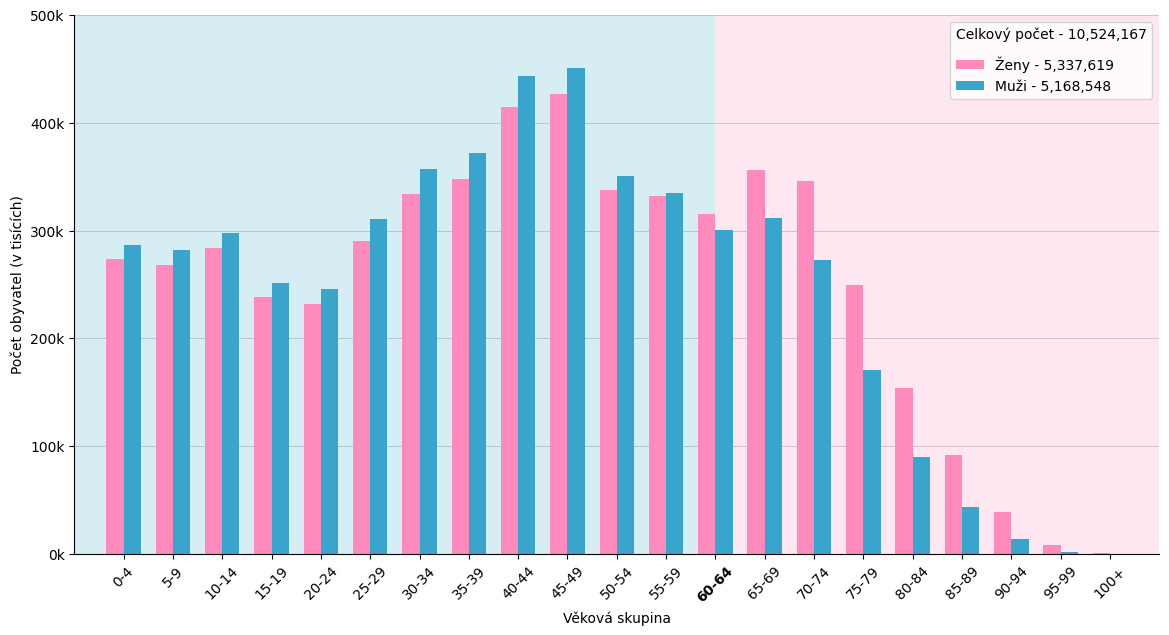

In [48]:
# Věkové kategorie a data
age_groups = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100+']
women_counts = [273743, 267952, 283743, 238290, 231724, 290569, 333508, 347389, 414631, 426913, 337187, 331655, 315642, 356534, 345900, 249134, 153868, 92099, 38676, 7926, 536]
men_counts = [286889, 282072, 297361, 251546, 245339, 310599, 357053, 371700, 443286, 450703, 350923, 334736, 300966, 311547, 272729, 170234, 89505, 43212, 14110, 1927, 111]

# women_colors = ['#ff8abbaa' for _ in range(12)] + ['#ff8abbff' for _ in range(9)]
# men_colors = ['#39a5ccff' for _ in range(12)] + ['#39a5ccaa' for _ in range(9)]

# Výpočet celkového počtu obyvatel, žen a mužů
total_population = sum(women_counts) + sum(men_counts)
total_women = sum(women_counts)
total_men = sum(men_counts)

women_counts_thousands = [count / 1000 for count in women_counts]
men_counts_thousands = [count / 1000 for count in men_counts]

# Šířka sloupců v histogramu
bar_width = 0.35

# Pozice pro skupiny sloupců
index = np.arange(len(age_groups))

# Vytvoření grafu
fig, ax = plt.subplots(figsize=(14, 7))

# Přidání spojnic pro ženy a muže
# ax.plot(age_groups, women_counts, color='#ff8abb')
# ax.plot(age_groups, men_counts, color='#39a5cc')

# Přidání sloupců pro ženy a muže
bar1 = ax.bar(index - bar_width/2, women_counts_thousands, bar_width, color='#ff8abb', label='Ženy - 5,337,619')
bar2 = ax.bar(index + bar_width/2, men_counts_thousands, bar_width, color='#39a5cc', label='Muži - 5,168,548')

# Přidání popisků, legendy a mřížky
ax.set_xlabel('Věková skupina')
ax.set_ylabel('Počet obyvatel (v tisících)')
# ax.set_title('Populace podle věkové skupiny a pohlaví')
ax.set_xticks(index)
ax.set_xticklabels(age_groups, rotation=45)
ax.legend()

# Přidání horizontálních mřížkových čar
ax.grid(axis='y', linestyle='-', color='grey', linewidth=0.5, alpha=0.5)
ax.set_axisbelow(True)  # Nastavení mřížky na pozadí

# Zvýraznění popisku pro skupinu '60-64' tučně
ax.get_xticklabels()[12].set_weight('bold')

# Odstranění ohraničení grafu
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# Přidání horizontální čáry na úrovni 50%, omezené na rozsah dat
# ax.vlines(x=12, ymin=10000, ymax=490000, colors='#404040', linestyles='--', linewidth=1)

# Parametry obdélníku: (levý spodní roh, šířka, výška)
rect = patches.Rectangle((-1, 0), 13, 500000, linewidth=1, facecolor='#39a5cc33', zorder=0)
rect2 = patches.Rectangle((12, 0), 9, 500000, linewidth=1, facecolor='#ff8abb33', zorder=0)

# Přidání obdélníku do grafu
ax.add_patch(rect)
ax.add_patch(rect2)

# Nastavení rozsahu os
ax.set_xlim(-1, 21)
ax.set_ylim(0, 500)

ax.set_yticklabels(['{:.0f}k'.format(y) for y in ax.get_yticks()])

# Přidání rozšířené legendy s dodatečným textem
legend = ax.legend(title="Celkový počet - 10,524,167")
legend._legend_box.align = "left"
legend._legend_box.sep = 10  # nastavení mezery mezi položkami

# Zobrazení grafu
plt.show()

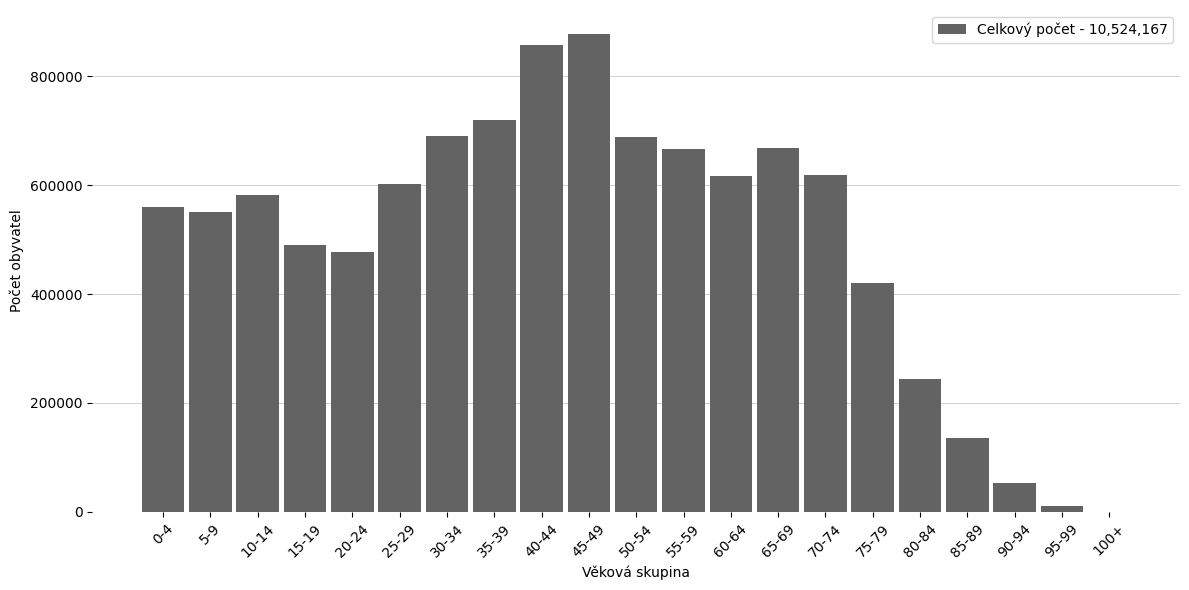

In [12]:
# Adjust the histogram to remove gaps between bars

# Věkové kategorie a data
age_groups = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100+']
counts = [560632, 550024, 581104, 489836, 477063, 601168, 690561, 719089, 857917, 877616, 688110, 666391, 616608, 668081, 618629, 419368, 243373, 135311, 52786, 9853, 647]

# Výpočet celkového počtu obyvatel
total_population = sum(counts)

# Šířka sloupců v histogramu
bar_width = 0.35

# Pozice pro skupiny sloupců
index = np.arange(len(age_groups))

# Vytvoření grafu
fig, ax = plt.subplots(figsize=(12, 6))

# Přidání sloupců bez mezer (bar width set to 1)
bar1 = ax.bar(index, counts, 0.9, color='#636363', label=f'Celkový počet - {total_population:,}')

# Přidání popisků, legendy a mřížky
ax.set_xlabel('Věková skupina')
ax.set_ylabel('Počet obyvatel')
ax.set_xticks(index)
ax.set_xticklabels(age_groups, rotation=45)
ax.legend()

# Přidání horizontálních mřížkových čar
ax.grid(axis='y', linestyle='-', color='grey', linewidth=0.5, alpha=0.5)
ax.set_axisbelow(True)  # Nastavení mřížky na pozadí

# Odstranění ohraničení grafu
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Zobrazení grafu
plt.tight_layout()
plt.show()


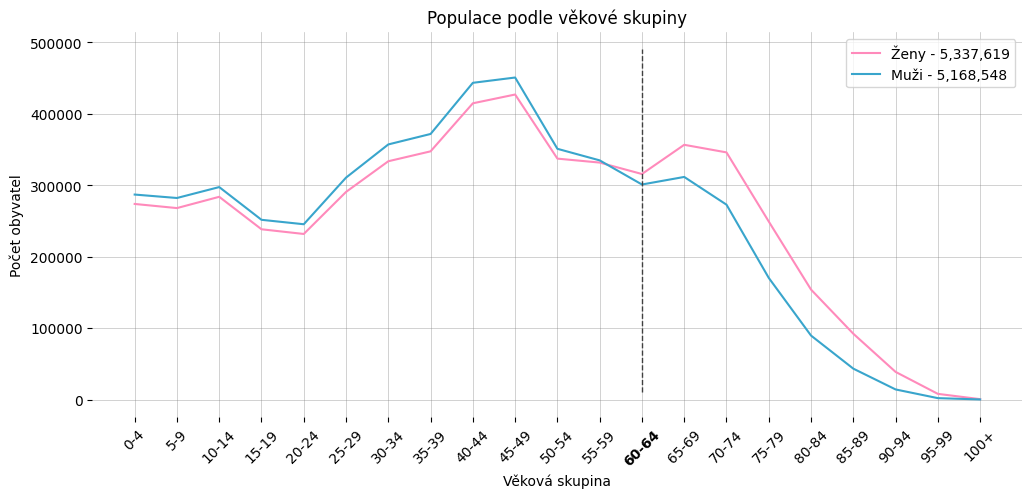

In [12]:
# Věkové kategorie a data
age_groups = ['0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100+']
women_counts = [273743, 267952, 283743, 238290, 231724, 290569, 333508, 347389, 414631, 426913, 337187, 331655, 315642, 356534, 345900, 249134, 153868, 92099, 38676, 7926, 536]
men_counts = [286889, 282072, 297361, 251546, 245339, 310599, 357053, 371700, 443286, 450703, 350923, 334736, 300966, 311547, 272729, 170234, 89505, 43212, 14110, 1927, 111]

# Vytvoření grafu
fig, ax = plt.subplots(figsize=(12, 5))

# Přidání spojnic pro ženy a muže
ax.plot(age_groups, women_counts, label='Ženy - 5,337,619', color='#ff8abb')
ax.plot(age_groups, men_counts, label='Muži - 5,168,548', color='#39a5cc')

# Přidání popisků, legendy a mřížky
ax.set_xlabel('Věková skupina')
ax.set_ylabel('Počet obyvatel')
ax.set_title('Populace podle věkové skupiny')
ax.set_xticks(np.arange(len(age_groups)))
ax.set_xticklabels(age_groups, rotation=45)
ax.legend()

# Přidání horizontálních mřížkových čar
ax.grid(axis='y', linestyle='-', color='grey', linewidth=0.5, alpha=0.5)
ax.grid(axis='x', linestyle='-', color='grey', linewidth=0.5, alpha=0.5)
ax.set_axisbelow(True)  # Nastavení mřížky na pozadí

# Zvýraznění popisku pro skupinu '60-64' tučně
ax.get_xticklabels()[12].set_weight('bold')

# Přidání horizontální čáry na úrovni 50%, omezené na rozsah dat
ax.vlines(x=12, ymin=10000, ymax=490000, colors='#404040', linestyles='--', linewidth=1)

# ax.set_yscale('log')

# Odstranění ohraničení grafu
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Zobrazení grafu
plt.show()

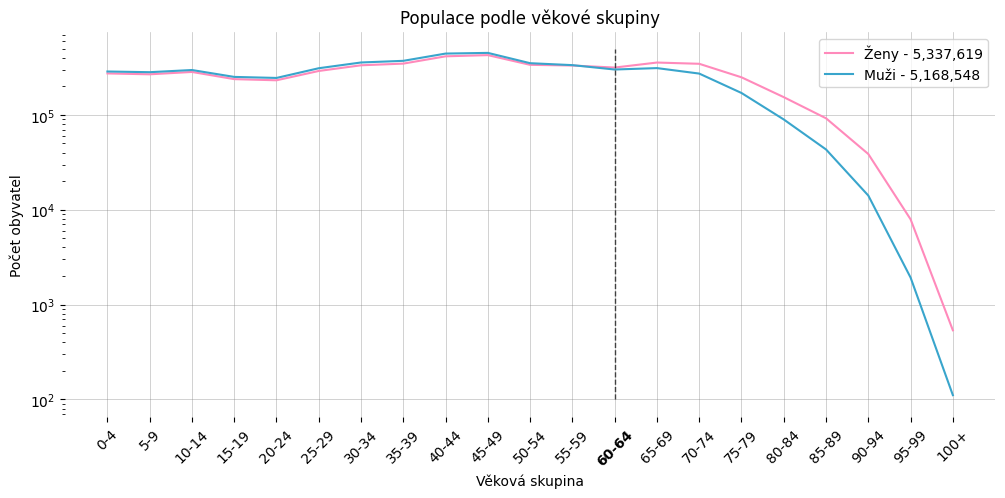

In [15]:
# Vytvoření grafu
fig, ax = plt.subplots(figsize=(12, 5))

# Přidání spojnic pro ženy a muže
ax.plot(age_groups, women_counts, label='Ženy - 5,337,619', color='#ff8abb')
ax.plot(age_groups, men_counts, label='Muži - 5,168,548', color='#39a5cc')

# Přidání popisků, legendy a mřížky
ax.set_xlabel('Věková skupina')
ax.set_ylabel('Počet obyvatel')
ax.set_title('Populace podle věkové skupiny')
ax.set_xticks(np.arange(len(age_groups)))
ax.set_xticklabels(age_groups, rotation=45)
ax.legend()

# Přidání horizontálních mřížkových čar
ax.grid(axis='y', linestyle='-', color='grey', linewidth=0.5, alpha=0.5)
ax.grid(axis='x', linestyle='-', color='grey', linewidth=0.5, alpha=0.5)
ax.set_axisbelow(True)  # Nastavení mřížky na pozadí

# Zvýraznění popisku pro skupinu '60-64' tučně
ax.get_xticklabels()[12].set_weight('bold')

# Přidání horizontální čáry na úrovni 50%, omezené na rozsah dat
ax.vlines(x=12, ymin=100, ymax=490000, colors='#404040', linestyles='--', linewidth=1)

ax.set_yscale('log')

# Odstranění ohraničení grafu
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Zobrazení grafu
plt.show()

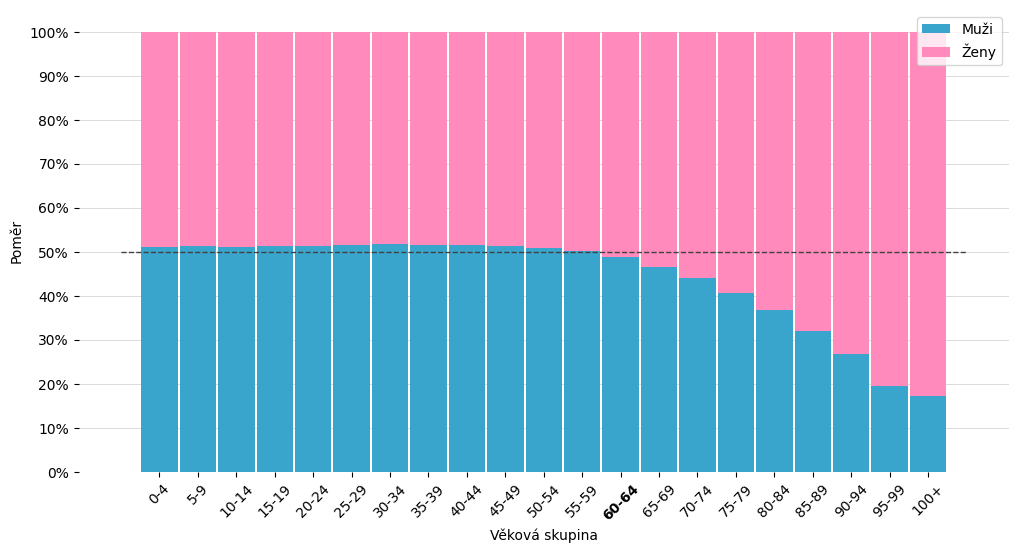

In [7]:
# Data pro zásobníkový sloupcový graf s normalizovanou výškou sloupců
age_groups = [
    '0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', 
    '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89', '90-94', '95-99', '100+'
]

# Počty mužů a žen z minulého dotazu
women_counts = [
    273743, 267952, 283743, 238290, 231724, 290569, 333508, 347389, 414631, 426913,
    337187, 331655, 315642, 356534, 345900, 249134, 153868, 92099, 38676, 7926, 536
]
men_counts = [
    286889, 282072, 297361, 251546, 245339, 310599, 357053, 371700, 443286, 450703,
    350923, 334736, 300966, 311547, 272729, 170234, 89505, 43212, 14110, 1927, 111
]

# Pozice pro skupiny sloupců
index = np.arange(len(age_groups))

# Výpočet poměrů pro každou skupinu
total_counts = [w + m for w, m in zip(women_counts, men_counts)]
women_ratios = [w / t for w, t in zip(women_counts, total_counts)]
men_ratios = [m / t for m, t in zip(men_counts, total_counts)]

# Vytvoření grafu s normalizovanými sloupci
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.95

# Nastavení výšky každého sloupce na 1 pro normalizaci
bar1 = ax.bar(age_groups, men_ratios, bar_width, label='Muži', color='#39a5cc')
bar2 = ax.bar(age_groups, women_ratios, bar_width, bottom=men_ratios, label='Ženy', color='#ff8abb')

# Přidání popisků a legendy
ax.set_xlabel('Věková skupina')
ax.set_ylabel('Poměr')
# ax.set_title('Poměr mužů a žen v dané věkové skupině')
ax.set_xticks(index)
ax.set_xticklabels(age_groups, rotation=45)
ax.legend()

# Odstranění ohraničení grafu
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Zvýraznění popisku pro skupinu '60-64' tučně
ax.get_xticklabels()[12].set_weight('bold')

# Přidání horizontální čáry na úrovni 50%, omezené na rozsah dat
ax.hlines(y=0.5, xmin=-1, xmax=len(age_groups), colors='#404040', linestyles='--', linewidth=1)

# Nastavení Y osy na procenta
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_yticklabels([f'{int(y*100)}%' for y in np.arange(0, 1.1, 0.1)])

ax.set_axisbelow(True)
ax.grid(True, which='major', linestyle='-', linewidth='0.5', color='#CCCCCC', axis='y')

# Zobrazení grafu
plt.show()

/tmp/ipykernel_6420/229028534.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])


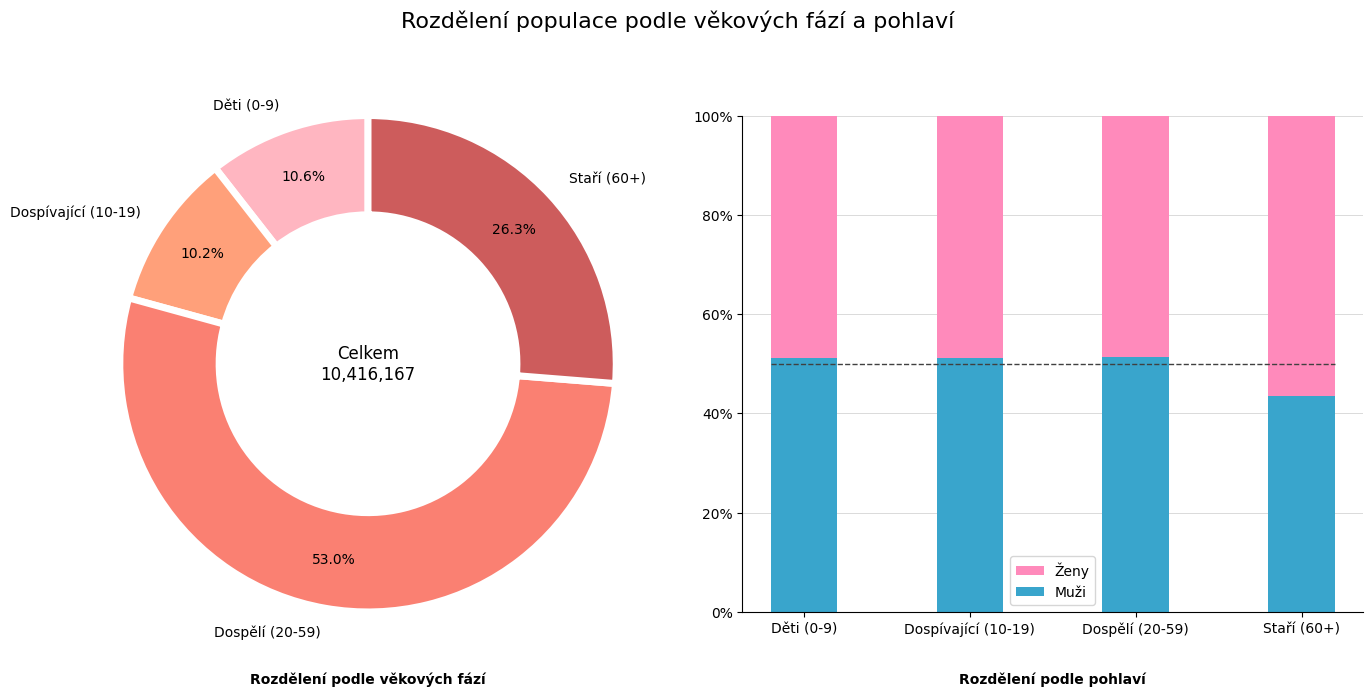

In [24]:
# Data pro oba grafy
group_names = ['Děti (0-9)', 'Dospívající (10-19)', 'Dospělí (20-59)', 'Staří (60+)']
group_sizes = [1110656, 1070940, 5577915, 2764656]  # Suma obyvatel v každé skupině
group_colors = ['#ffb6c1', '#ffa07a', '#fa8072', '#cd5c5c']

# Data pro 100% zásobníkový sloupcový graf
women_counts = [541695, 522033, 2713576, 1560315]
men_counts = [568961, 548907, 2864339, 1204341]
total_counts = [sum(x) for x in zip(women_counts, men_counts)]
women_ratios = [w / t for w, t in zip(women_counts, total_counts)]
men_ratios = [m / t for m, t in zip(men_counts, total_counts)]

# Vytvoření grafu
fig, axs = plt.subplots(1, 2, figsize=(14, 7))

# První část: Koláčový graf podle věkových kategorií
axs[0].pie(group_sizes, labels=group_names, colors=group_colors, autopct='%1.1f%%', pctdistance=0.8, startangle=90, wedgeprops=dict(width=0.4, edgecolor='w', linewidth=5))
axs[0].set_xlabel('Rozdělení podle věkových fází', fontdict={'weight': 'bold'})
axs[0].xaxis.set_label_coords(0.5, 0.004)

# Vložení textu do středu grafu
axs[0].text(0, 0, "Celkem\n10,416,167", ha='center', va='center', fontsize=12, color='black')

# Druhá část: 100% zásobníkový sloupcový graf
ind = np.arange(len(group_names))
axs[1].set_box_aspect(0.8)
axs[1].bar(ind, women_ratios, label='Ženy', bottom=men_ratios, color='#ff8abb', width=0.4)
axs[1].bar(ind, men_ratios, label='Muži', color='#39a5cc', width=0.4)
axs[1].set_xticks(ind)
axs[1].set_xticklabels(group_names)
axs[1].set_ylim(0, 1)
axs[1].set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
axs[1].set_xlabel('Rozdělení podle pohlaví', fontdict={'weight': 'bold'})
axs[1].xaxis.set_label_coords(0.5, -0.12)
axs[1].legend()
axs[1].set_axisbelow(True)
axs[1].grid(True, which='major', linestyle='-', linewidth='0.5', color='#CCCCCC', axis='y')

# Odstranění ohraničení grafu
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

# Přidání horizontální čáry na úrovni 50%, omezené na rozsah dat
axs[1].hlines(y=0.5, xmin=-0.2, xmax=len(group_names)-0.8, colors='#404040', linestyles='--', linewidth=1)

# Titulek
fig.suptitle('Rozdělení populace podle věkových fází a pohlaví', fontsize=16)

# Zobrazení grafu
plt.tight_layout()
plt.show()

/tmp/ipykernel_6420/501860062.py:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels(['{:.0f}k'.format(y) for y in axs[0].get_yticks()])
/tmp/ipykernel_6420/501860062.py:69: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['{:.0f}k'.format(y) for y in axs[1].get_yticks()])


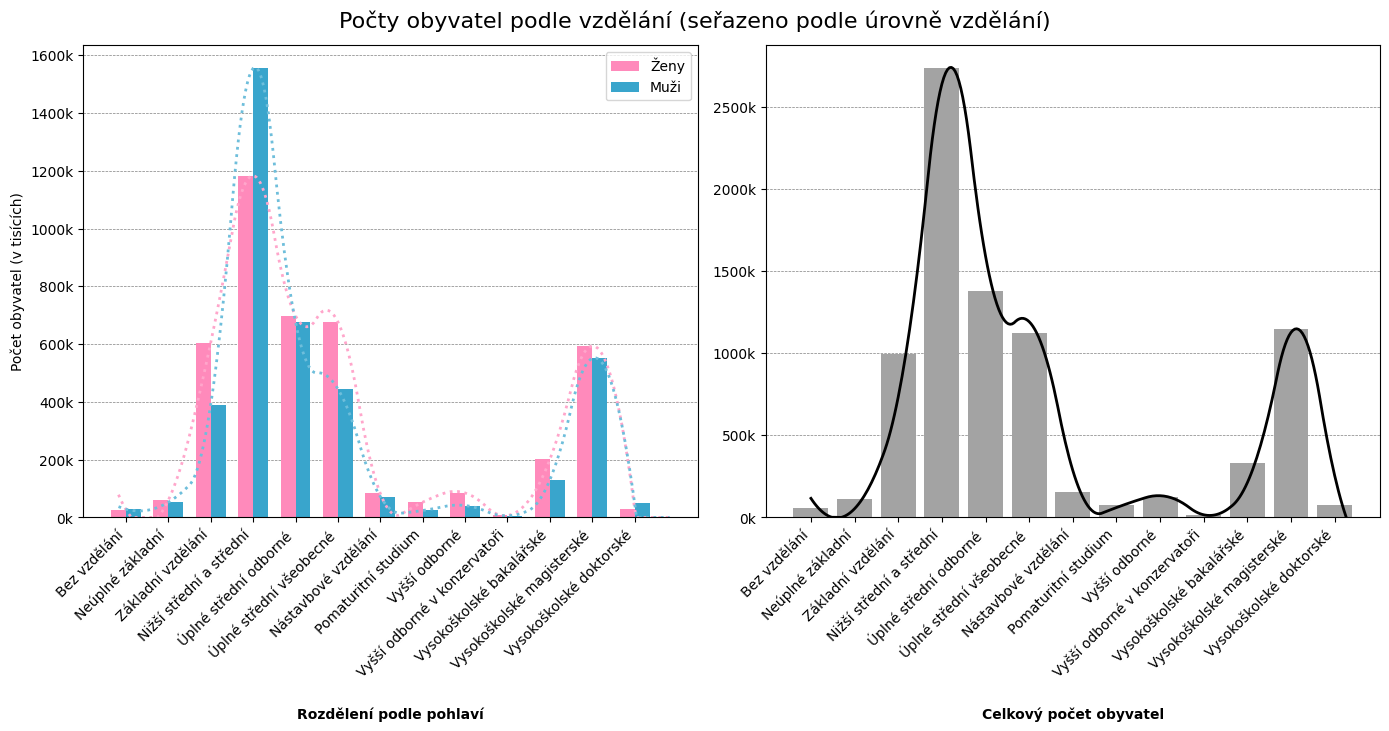

In [3]:
from scipy.interpolate import make_interp_spline

# Definice dat
education_levels = [
    'Bez vzdělání', 'Neúplné základní', 'Základní vzdělání', 
    'Nižší střední a střední', 'Úplné střední odborné', 'Úplné střední všeobecné',
    'Nástavbové vzdělání', 'Pomaturitní studium', 'Vyšší odborné',
    'Vyšší odborné v konzervatoři', 'Vysokoškolské bakalářské',
    'Vysokoškolské magisterské', 'Vysokoškolské doktorské'
]
women_counts = [27440, 59781, 604955, 1182747, 698167, 676678, 83119, 52977, 84747, 6871, 200884, 593633, 28679]
men_counts = [28660, 52684, 390440, 1554236, 676965, 444829, 72232, 24124, 41243, 5727, 130105, 550699, 48407]
total_counts = [w + m for w, m in zip(women_counts, men_counts)]  # Celkový počet pro každou kategorii

# Vytvoření histogramu s popisky v tisících a přidáním křivky symbolizující celkový počet
x = np.arange(len(education_levels))  # Pozice na ose x pro skupiny
x_1 = np.arange(len(education_levels))
x_1 = np.concatenate([x, np.arange(1)])
bar_width = 0.35  # Šířka sloupce

# Převod počtů na tisíce pro lepší čitelnost popisků
women_counts_thousands = [count / 1000 for count in women_counts]
men_counts_thousands = [count / 1000 for count in men_counts]
total_counts_thousands = [count / 1000 for count in total_counts]

# Spline interpolace a úprava křivky
total_counts_adjusted = total_counts_thousands + [0]  # Přidání 0 jako poslední bod
spl = make_interp_spline(np.append(x + bar_width / 2, x.max() + 1.35), total_counts_adjusted, k=2)  # Přidání rozšířeného bodu pro spline
xnew = np.linspace(x.min(), x.max() + 1, 300)  # Rozšíření x osy o jeden bod doprava
y_smooth = spl(xnew)

# Odstranění záporných bodů z křivky
x_filtered = xnew[y_smooth >= 0]
y_filtered = y_smooth[y_smooth >= 0]

# Spline interpolace pro ženy a muže
spl_women = make_interp_spline(x + bar_width / 2, women_counts_thousands, k=2)
spl_men = make_interp_spline(x + bar_width / 2, men_counts_thousands, k=2)

# Filtrace záporných hodnot
y_smooth_women = np.maximum(spl_women(xnew), 0)
y_smooth_men = np.maximum(spl_men(xnew), 0)
y_filtered_women = y_smooth_women[y_smooth_women >= 0]
y_filtered_men = y_smooth_men[y_smooth_men >= 0]

# Vytvoření skupiny grafů, kde vlevo bude histogram a vpravo graf celkových počtů s křivkou
fig, axs = plt.subplots(1, 2, figsize=(14, 8))  # Rozšířené okno pro dva grafy

# První graf: Histogram s rozdělením podle pohlaví a úrovně vzdělání
axs[0].bar(x, women_counts_thousands, width=bar_width, label='Ženy', color='#ff8abb')
axs[0].bar(x + bar_width, men_counts_thousands, width=bar_width, label='Muži', color='#39a5cc')
axs[0].plot(xnew, y_filtered_women, color='#ffa6cb', linestyle='dotted', linewidth=2)
axs[0].plot(xnew, y_filtered_men, color='#6ebedb', linestyle='dotted', linewidth=2)
axs[0].set_ylabel('Počet obyvatel (v tisících)')
axs[0].set_xticks(x + bar_width / 2)
axs[0].set_xticklabels(education_levels, rotation=45, ha='right')
axs[0].set_yticklabels(['{:.0f}k'.format(y) for y in axs[0].get_yticks()])
axs[0].set_axisbelow(True)
axs[0].grid(True, which='major', linestyle='--', linewidth='0.5', color='gray', axis='y')
axs[0].legend()
axs[0].set_xlabel('Rozdělení podle pohlaví', fontdict={'weight': 'bold'})
axs[0].xaxis.set_label_coords(0.5, -0.4)

# Druhý graf: Pouze celkové počty s křivkou
axs[1].bar(x, total_counts_thousands, color='#a3a3a3', label='Celkový počet')
axs[1].plot(x_filtered, y_filtered, label='Celkový počet', color='black', linestyle='-', linewidth=2)
axs[1].set_xticks(x)
axs[1].set_xticklabels(education_levels, rotation=45, ha='right')
axs[1].set_yticklabels(['{:.0f}k'.format(y) for y in axs[1].get_yticks()])
axs[1].set_axisbelow(True)
axs[1].grid(True, which='major', linestyle='--', linewidth='0.5', color='gray', axis='y')
axs[1].set_xlabel('Celkový počet obyvatel', fontdict={'weight': 'bold'})
axs[1].xaxis.set_label_coords(0.5, -0.4)

# Titulek
fig.suptitle('Počty obyvatel podle vzdělání (seřazeno podle úrovně vzdělání)', fontsize=16)

plt.tight_layout()
plt.show()

# Consolas, 'Courier New', monospace

/tmp/ipykernel_301/3020603773.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_yticklabels(['{:.0f}k'.format(y) for y in axs.get_yticks()])


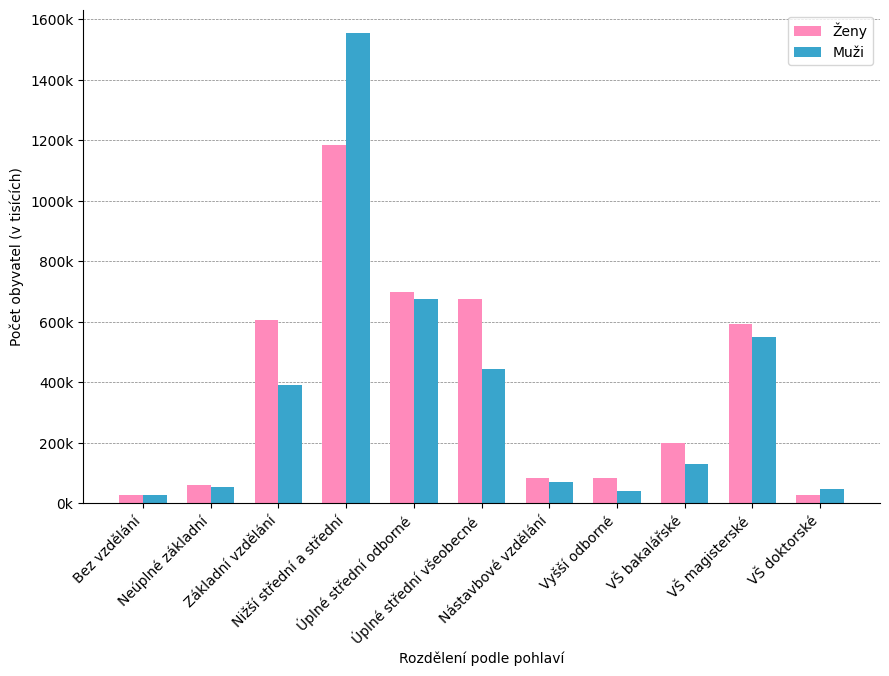

In [46]:
from scipy.interpolate import make_interp_spline

# Definice dat
education_levels = [
    'Bez vzdělání', 
    'Neúplné základní', 
    'Základní vzdělání', 
    'Nižší střední a střední', 
    'Úplné střední odborné', 
    'Úplné střední všeobecné',
    'Nástavbové vzdělání', 
    'Vyšší odborné',
    'VŠ bakalářské',
    'VŠ magisterské', 
    'VŠ doktorské'
]
women_counts = [27440, 59781, 604955, 1182747, 698167, 676678, 83119, 84747, 200884, 593633, 28679]
men_counts = [28660, 52684, 390440, 1554236, 676965, 444829, 72232, 41243, 130105, 550699, 48407]
total_counts = [w + m for w, m in zip(women_counts, men_counts)]  # Celkový počet pro každou kategorii

# Vytvoření histogramu s popisky v tisících a přidáním křivky symbolizující celkový počet
x = np.arange(len(education_levels))  # Pozice na ose x pro skupiny
x_1 = np.arange(len(education_levels))
x_1 = np.concatenate([x, np.arange(1)])
bar_width = 0.35  # Šířka sloupce

# Převod počtů na tisíce pro lepší čitelnost popisků
women_counts_thousands = [count / 1000 for count in women_counts]
men_counts_thousands = [count / 1000 for count in men_counts]
total_counts_thousands = [count / 1000 for count in total_counts]

# Spline interpolace a úprava křivky
total_counts_adjusted = total_counts_thousands + [0]  # Přidání 0 jako poslední bod
spl = make_interp_spline(np.append(x + bar_width / 2, x.max() + 1.35), total_counts_adjusted, k=2)  # Přidání rozšířeného bodu pro spline
xnew = np.linspace(x.min(), x.max() + 1, 300)  # Rozšíření x osy o jeden bod doprava
y_smooth = spl(xnew)

# Odstranění záporných bodů z křivky
x_filtered = xnew[y_smooth >= 0]
y_filtered = y_smooth[y_smooth >= 0]

# Spline interpolace pro ženy a muže
spl_women = make_interp_spline(x + bar_width / 2, women_counts_thousands, k=2)
spl_men = make_interp_spline(x + bar_width / 2, men_counts_thousands, k=2)

# Filtrace záporných hodnot
y_smooth_women = np.maximum(spl_women(xnew), 0)
y_smooth_men = np.maximum(spl_men(xnew), 0)
y_filtered_women = y_smooth_women[y_smooth_women >= 0]
y_filtered_men = y_smooth_men[y_smooth_men >= 0]

# Vytvoření skupiny grafů, kde vlevo bude histogram a vpravo graf celkových počtů s křivkou
fig, axs = plt.subplots(1, 1, figsize=(9, 7))  # Rozšířené okno pro dva grafy

# První graf: Histogram s rozdělením podle pohlaví a úrovně vzdělání
axs.bar(x, women_counts_thousands, width=bar_width, label='Ženy', color='#ff8abb')
axs.bar(x + bar_width, men_counts_thousands, width=bar_width, label='Muži', color='#39a5cc')
# axs.plot(xnew, y_filtered_women, color='#ffa6cb', linestyle='dotted', linewidth=2)
# axs.plot(xnew, y_filtered_men, color='#6ebedb', linestyle='dotted', linewidth=2)
axs.set_ylabel('Počet obyvatel (v tisících)')
axs.set_xticks(x + bar_width / 2)
axs.set_xticklabels(education_levels, rotation=45, ha='right')
axs.set_yticklabels(['{:.0f}k'.format(y) for y in axs.get_yticks()])
axs.set_axisbelow(True)
axs.grid(True, which='major', linestyle='--', linewidth='0.5', color='gray', axis='y')
axs.legend()
axs.set_xlabel('Rozdělení podle pohlaví')
axs.xaxis.set_label_coords(0.5, -0.3)

# Odstranění ohraničení grafu
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
# axs.spines['left'].set_visible(False)
# axs.spines['bottom'].set_visible(False)

# Titulek
# fig.suptitle('Počty obyvatel podle vzdělání (seřazeno podle úrovně vzdělání)', fontsize=16)

plt.tight_layout()
plt.show()

# Consolas, 'Courier New', monospace

### udelat histogram vzdelani podle pohlavi, vzdy pridavat predchozi pocty k vyssim vzdelanim a sledovat rust pohlavi

In [39]:
# Histogram - poměr celkového počtu lidí / počtu vysokoškolsky vzdělaných lidí podle rozlohy v různě velkých městech, obcích apod.

# Načtení JSON s rozlohami obcí
with open('data/obce_kod_rozloha.json') as f:
    obce_rozlohy = json.load(f)['obce_kod_rozloha']

# Načtení JSON s počtem obyv obcí
with open('data/obce_kod_pocet.json') as f:
    obce_pocty = json.load(f)['obce_kod_pocet']

# Slovník pro ukládání poměrů vysokoškolsky vzdělaných obyvatel
obce_pomery = {}

# Iterace přes všechny obce a výpočet poměru vzdělanosti
for obec, rozloha in obce_rozlohy.items():
    obec_data = data[(data['uzemi_cis'] == 43) & (data['uzemi_kod'] == int(obec)) & (data['pohlavi_kod'].isna()) & (data['vek_txt'].isin(['15 - 64 let', '65 a více let']))]
    pocet_vzdelanych_lidi = 0
    pocet_celkem_v_obci = obce_pocty[obec]

    for vysokoskolske_vzdelani in vzdelani_podle_typu['vysokoskolske_vzdelani']:
        pocet_vzdelanych_lidi += obec_data[obec_data['vzdelani_txt'] == vysokoskolske_vzdelani]['hodnota'].sum()

    if pocet_celkem_v_obci > 0:
        pomer = (pocet_vzdelanych_lidi / pocet_celkem_v_obci) * 100
        obce_pomery[obec] = {'rozloha': rozloha, 'pomer': pomer}

<BarContainer object of 50 artists>

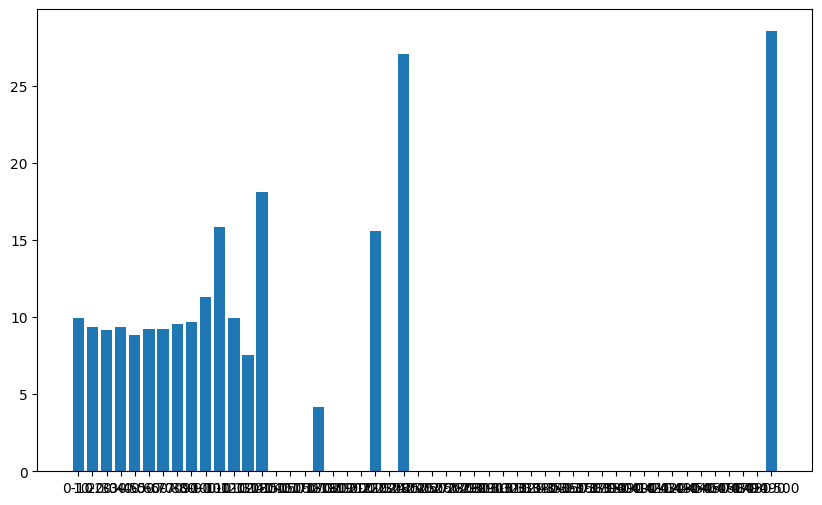

In [42]:
# Příprava dat pro histogram
df_pomery = pd.DataFrame(obce_pomery).T
bins = np.arange(0, df_pomery['rozloha'].max() + 10, 10)
df_pomery['rozloha_kategorie'] = pd.cut(df_pomery['rozloha'], bins=bins, labels=[f"{int(left)}-{int(right)}" for left, right in zip(bins[:-1], bins[1:])])

# Výpočet průměrných poměrů pro každou kategorii rozlohy
result_df = df_pomery.groupby('rozloha_kategorie')['pomer'].mean()

# Vytvoření histogramu
plt.figure(figsize=(10, 6))
plt.bar(result_df.index, result_df.values)

In [44]:
# Histogram - poměr celkového počtu lidí / počtu vysokoškolsky vzdělaných lidí podle rozlohy v různě velkých městech, obcích apod.

# Načtení JSON s rozlohami obcí
with open('data/obce_kod_rozloha.json') as f:
    obce_rozlohy = json.load(f)['obce_kod_rozloha']

# Načtení JSON s počtem obyv obcí
with open('data/obce_kod_pocet.json') as f:
    obce_pocty = json.load(f)['obce_kod_pocet']

# Slovník pro ukládání poměrů vysokoškolsky vzdělaných obyvatel
obce_pomery_2 = {}

# Iterace přes všechny obce a výpočet poměru vzdělanosti
for obec, rozloha in obce_rozlohy.items():
    obec_data = data[(data['uzemi_cis'] == 43) & (data['uzemi_kod'] == int(obec)) & (data['pohlavi_kod'].isna()) & (data['vek_txt'].isin(['15 - 64 let', '65 a více let']))]
    pocet_vzdelanych_lidi = 0
    pocet_celkem_v_obci = obce_pocty[obec]

    for vysokoskolske_vzdelani in vzdelani_podle_typu['vysokoskolske_vzdelani']:
        pocet_vzdelanych_lidi += obec_data[obec_data['vzdelani_txt'] == vysokoskolske_vzdelani]['hodnota'].sum()

    if pocet_celkem_v_obci > 0:
        pomer = (pocet_vzdelanych_lidi / pocet_celkem_v_obci) * 100
        obce_pomery_2[obec] = {'celkem': pocet_celkem_v_obci, 'pomer': pomer}

In [48]:
obce_pomery_2

{'500011': {'celkem': 1817, 'pomer': 14.254265272427077},
 '500020': {'celkem': 1195, 'pomer': 7.280334728033473},
 '500046': {'celkem': 1699, 'pomer': 11.771630370806356},
 '500062': {'celkem': 2020, 'pomer': 13.712871287128714},
 '500071': {'celkem': 1716, 'pomer': 12.062937062937063},
 '500101': {'celkem': 212, 'pomer': 2.358490566037736},
 '500127': {'celkem': 147, 'pomer': 6.802721088435375},
 '500135': {'celkem': 220, 'pomer': 7.2727272727272725},
 '500151': {'celkem': 105, 'pomer': 8.571428571428571},
 '500160': {'celkem': 529, 'pomer': 6.994328922495274},
 '500194': {'celkem': 198, 'pomer': 3.0303030303030303},
 '500259': {'celkem': 1914, 'pomer': 11.80773249738767},
 '500291': {'celkem': 2731, 'pomer': 23.214939582570487},
 '500496': {'celkem': 106063, 'pomer': 22.686516504341757},
 '500526': {'celkem': 2271, 'pomer': 11.668868339938353},
 '500623': {'celkem': 1106, 'pomer': 8.679927667269439},
 '500801': {'celkem': 647, 'pomer': 10.35548686244204},
 '500852': {'celkem': 2383,

<BarContainer object of 1302 artists>

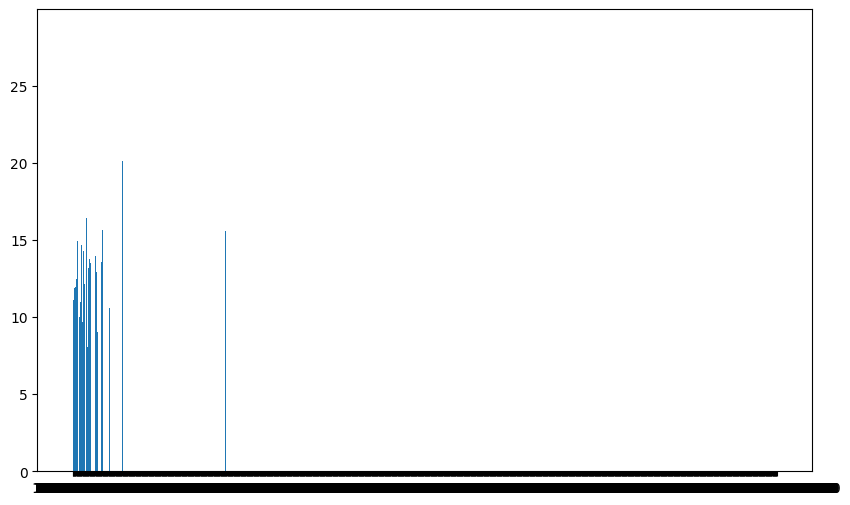

In [47]:
# Příprava dat pro histogram
df_pomery = pd.DataFrame(obce_pomery_2).T
bins = np.arange(0, df_pomery['celkem'].max() + 1000, 1000)
df_pomery['rozloha_kategorie'] = pd.cut(df_pomery['celkem'], bins=bins, labels=[f"{int(left)}-{int(right)}" for left, right in zip(bins[:-1], bins[1:])])

# Výpočet průměrných poměrů pro každou kategorii rozlohy
result_df = df_pomery.groupby('rozloha_kategorie')['pomer'].mean()

# Vytvoření histogramu
plt.figure(figsize=(10, 6))
plt.bar(result_df.index, result_df.values)

# Analýza datasetu "Obyvatelstvo podle náboženství"

AttributeError: module 'matplotlib.pyplot' has no attribute 'axisbelow'

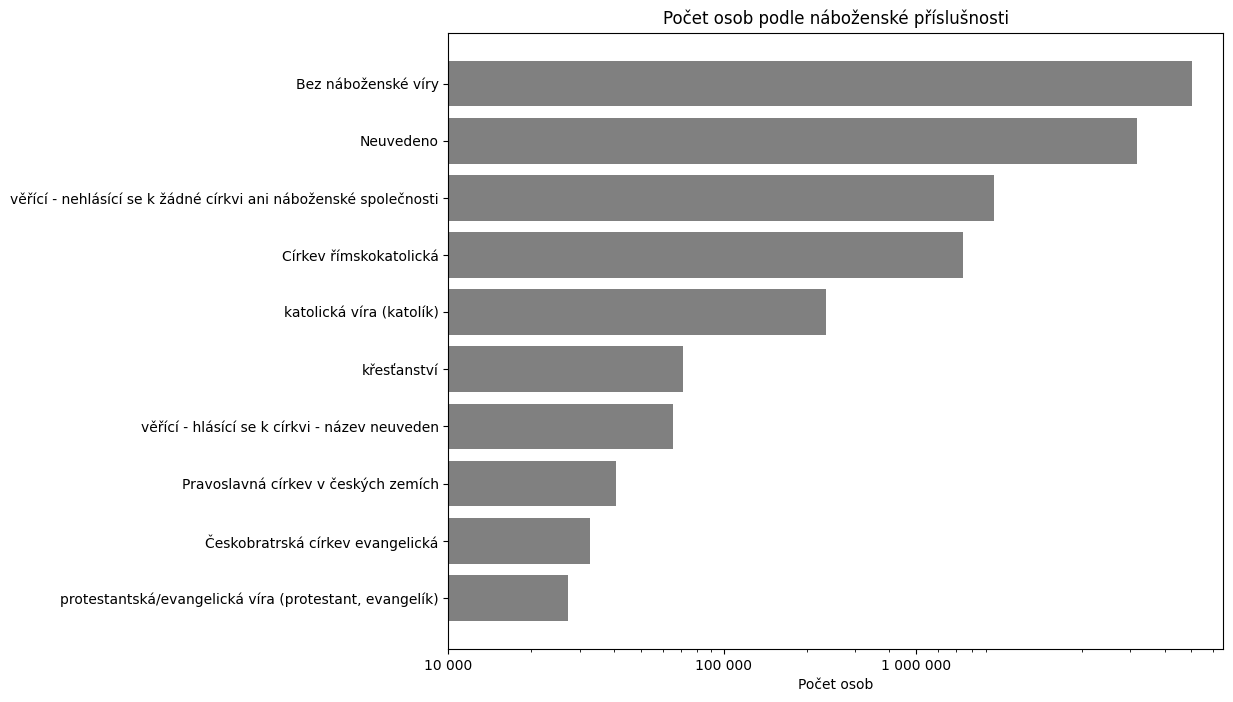

In [29]:
import json

# Načtení JSON s počtem obyv obcí
with open('data/obce_kod_pocet.json') as f:
    obce_pocty = json.load(f)['obce_kod_pocet']

# Data
categories = [
    "Bez náboženské víry",
    "Neuvedeno",
    "věřící - nehlásící se k žádné církvi ani náboženské společnosti",
    "Církev římskokatolická",
    "katolická víra (katolík)",
    "křesťanství",
    "věřící - hlásící se k církvi - název neuveden",
    "Pravoslavná církev v českých zemích",
    "Českobratrská církev evangelická",
    "protestantská/evangelická víra (protestant, evangelík)"
]
values = [5027141, 3162540, 960201, 741019, 235834, 71089, 65567, 40681, 32577, 27149]

# Creating the bar chart
plt.figure(figsize=(10, 8))
plt.barh(categories, values, color='grey')
plt.xlabel('Počet osob')
plt.title('Počet osob podle náboženské příslušnosti')
plt.gca().invert_yaxis()  # Invert y axis to have the largest group on top
plt.xscale('log')
plt.xticks([10000, 100000, 500000], ['10 000', '100 000', '1 000 000'])  # Custom x-axis scale units
plt.axisbelow(True)
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='#CCCCCC', axis='y')
plt.show()

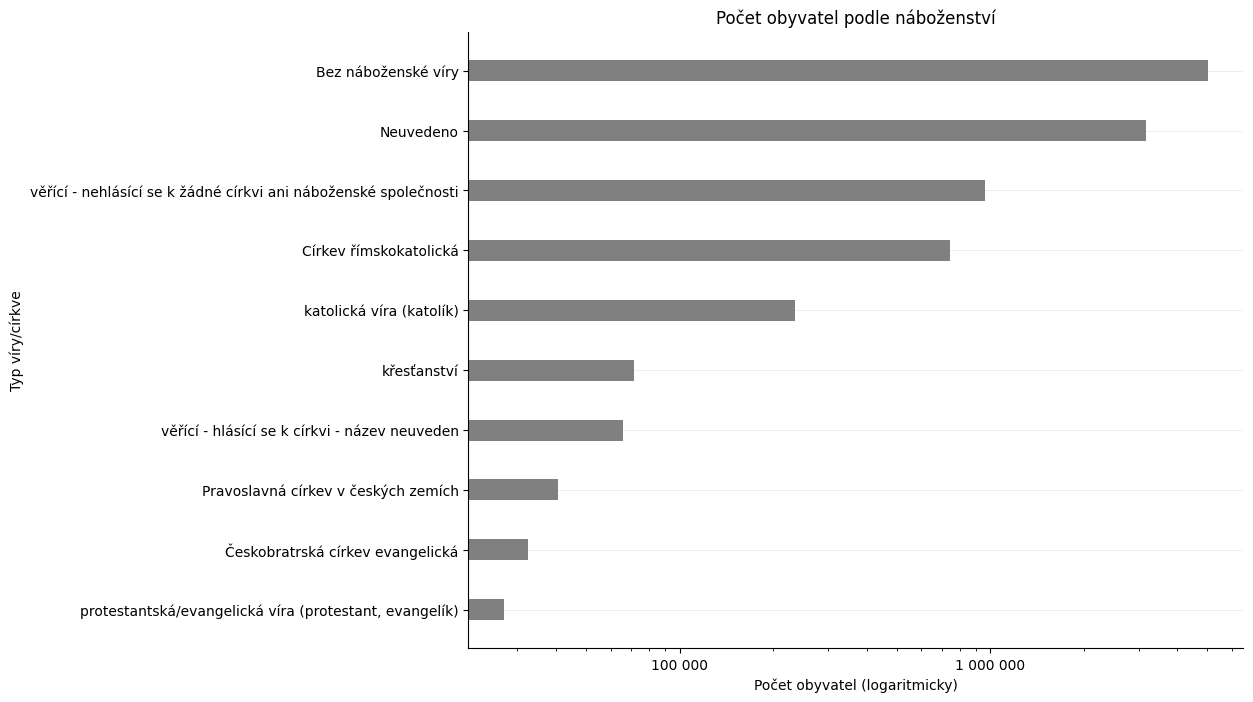

In [55]:
# Data
categories = [
    "Bez náboženské víry",
    "Neuvedeno",
    "věřící - nehlásící se k žádné církvi ani náboženské společnosti",
    "Církev římskokatolická",
    "katolická víra (katolík)",
    "křesťanství",
    "věřící - hlásící se k církvi - název neuveden",
    "Pravoslavná církev v českých zemích",
    "Českobratrská církev evangelická",
    "protestantská/evangelická víra (protestant, evangelík)"
]
values = [5027141, 3162540, 960201, 741019, 235834, 71089, 65567, 40681, 32577, 27149]

# Šířka sloupců v histogramu
bar_width = 0.35

# Vytvoření grafu
fig, ax = plt.subplots(figsize=(10, 8))

# Přidání sloupců pro ženy a muže
bar1 = ax.barh(categories, values, bar_width, color='grey', label='Ženy - 5,337,619')

# Přidání popisků, legendy a mřížky
ax.set_xlabel('Počet obyvatel (logaritmicky)')
ax.set_ylabel('Typ víry/církve')
ax.set_title('Počet obyvatel podle náboženství')

# Přidání horizontálních mřížkových čar
ax.grid(axis='y', linestyle='-', color='grey', linewidth=0.5, alpha=0.5)
ax.set_axisbelow(True)  # Nastavení mřížky na pozadí
plt.gca().invert_yaxis()  # Invert y axis to have the largest group on top

# Odstranění ohraničení grafu
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# lmao
plt.xscale('log')
plt.xticks([100000, 1000000], ['100 000', '1 000 000'])  # Custom x-axis scale units
# ax.set_axisbelow(True)
plt.grid(True, which='major', linestyle='-', linewidth='0.5', color='#CCCCCC', axis='y')
plt.show()

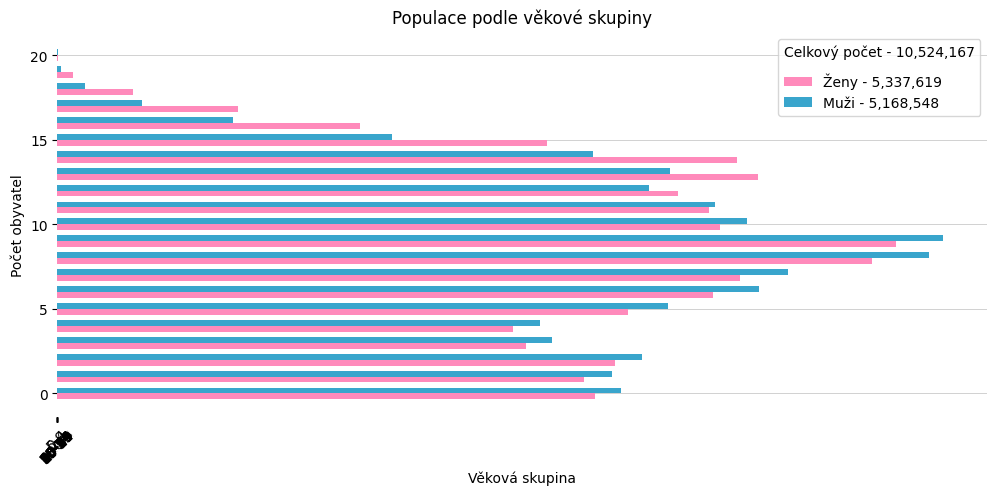

In [50]:


# Data
categories = [
    "Bez náboženské víry",
    "Neuvedeno",
    "věřící - nehlásící se k žádné církvi ani náboženské společnosti",
    "Církev římskokatolická",
    "katolická víra (katolík)",
    "křesťanství",
    "věřící - hlásící se k církvi - název neuveden",
    "Pravoslavná církev v českých zemích",
    "Českobratrská církev evangelická",
    "protestantská/evangelická víra (protestant, evangelík)"
]
values_men = []
values_women = [5027141, 3162540, 960201, 741019, 235834, 71089, 65567, 40681, 32577, 27149]

# Šířka sloupců v histogramu
bar_width = 0.35

# Pozice pro skupiny sloupců
index = np.arange(len(age_groups))

# Vytvoření grafu
fig, ax = plt.subplots(figsize=(12, 5))

# Přidání sloupců pro ženy a muže
bar1 = ax.barh(index - bar_width/2, women_counts, bar_width, color='#ff8abb', label='Ženy - 5,337,619')
bar2 = ax.barh(index + bar_width/2, men_counts, bar_width, color='#39a5cc', label='Muži - 5,168,548')

# Přidání popisků, legendy a mřížky
ax.set_xlabel('Věková skupina')
ax.set_ylabel('Počet obyvatel')
ax.set_title('Populace podle věkové skupiny')
ax.set_xticks(index)
ax.set_xticklabels(age_groups, rotation=45)
ax.legend()

# Přidání horizontálních mřížkových čar
ax.grid(axis='y', linestyle='-', color='grey', linewidth=0.5, alpha=0.5)
ax.set_axisbelow(True)  # Nastavení mřížky na pozadí

# Odstranění ohraničení grafu
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

# Přidání rozšířené legendy s dodatečným textem
legend = ax.legend(title="Celkový počet - 10,524,167")
legend._legend_box.align = "left"
legend._legend_box.sep = 10  # nastavení mezery mezi položkami

# Zobrazení grafu
plt.show()

In [107]:
# Nahrazení 'cesta_k_souboru.csv' cestou k vašemu CSV souboru
data = pd.read_csv('../data_original/sldb2021_vira_pohlavi.csv')

# Filtrujeme data pro území 'Česká republika'
filtered_data = data[data['uzemi_txt'] == 'Česká republika']

# Seskupíme data podle typu náboženství a pohlaví, a spočítáme součet věřících
grouped_data = filtered_data.groupby(['vira_txt', 'pohlavi_kod'])['hodnota'].sum().unstack(fill_value=0)

# Přidáme sloupec pro celkový počet věřících
grouped_data['Celkem'] = grouped_data.sum(axis=1)

# Vypočítáme procentuální zastoupení mužů a žen
grouped_data['Procento mužů'] = (grouped_data[1] / grouped_data['Celkem']) * 100
grouped_data['Procento žen'] = (grouped_data[2] / grouped_data['Celkem']) * 100

# Seřadíme náboženství podle celkového počtu věřících sestupně a vezmeme prvních 15
top_religions = grouped_data.sort_values(by='Procento mužů', ascending=False).head(15)

# Přejmenování sloupců pro lepší čitelnost
top_religions.columns = ['Muži', 'Ženy', 'Celkem', 'Procento mužů', 'Procento žen']

print(top_religions[['Celkem', 'Muži', 'Ženy', 'Procento mužů', 'Procento žen']])

                                          Celkem   Muži  Ženy  Procento mužů  \
vira_txt                                                                       
Společenství buddhismu v České republice       1      1     0     100.000000   
deismus                                        8      7     1      87.500000   
rastafariánství                              190    163    27      85.789474   
Sith                                         516    442    74      85.658915   
konfucianismus                                13     11     2      84.615385   
zoroastrismus                                 76     64    12      84.210526   
druidismus                                   189    156    33      82.539683   
pastafariánství                             2696   2130   566      79.005935   
Jedi                                       21023  16467  4556      78.328497   
satanismus                                   998    770   228      77.154309   
taoismus                                

NameError: name 'legend' is not defined

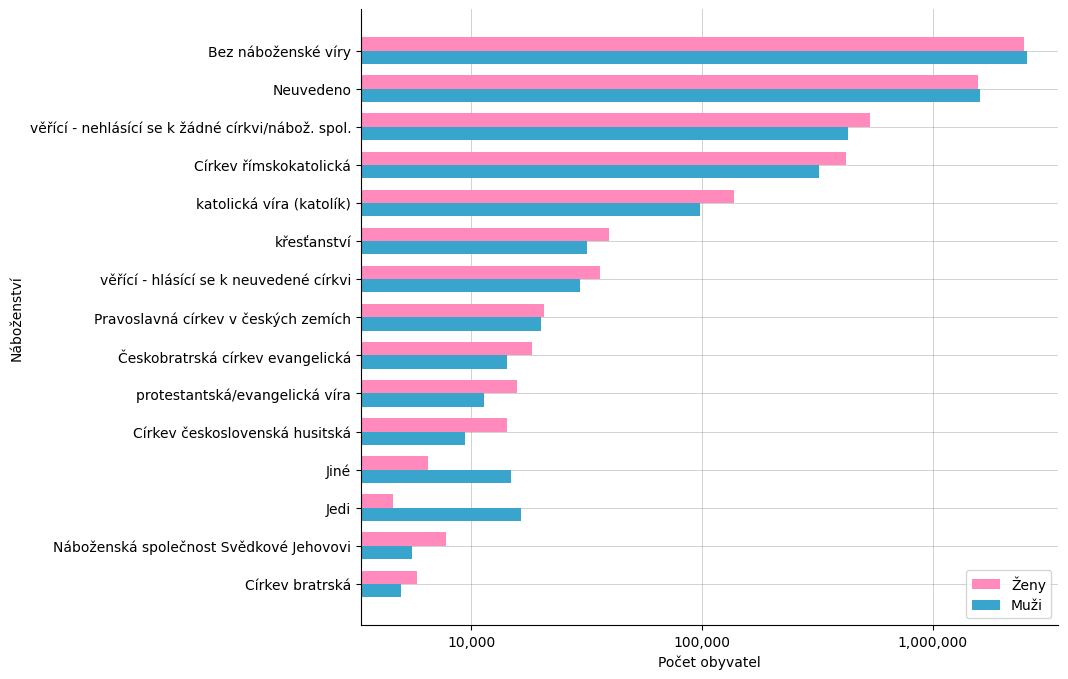

In [40]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter

# Funkce pro formátování s čárkami
def thousand_separator(x, pos):
    return '{:,.0f}'.format(x)

data = {
    'Náboženství': [
        'Bez náboženské víry', 'Neuvedeno', 'věřící - nehlásící se k žádné církvi/nábož. spol.',
        'Církev římskokatolická', 'katolická víra (katolík)', 'křesťanství',
        'věřící - hlásící se k neuvedené církvi', 'Pravoslavná církev v českých zemích',
        'Českobratrská církev evangelická', 'protestantská/evangelická víra',
        'Církev československá husitská', 'Jiné', 'Jedi',
        'Náboženská společnost Svědkové Jehovovi', 'Církev bratrská'
    ],
    'Muži': [2548297, 1597650, 428890, 319472, 97797, 31638, 29469, 19974, 14241, 11346, 9387, 14806, 16467, 5548, 4958],
    'Ženy': [2478844, 1564890, 531311, 421547, 138037, 39451, 36098, 20707, 18336, 15803, 14223, 6502, 4556, 7750, 5804]
}

# Šířka sloupců v histogramu
bar_width = 0.35

# Pozice pro skupiny sloupců
index = np.arange(len(data['Náboženství']))

# Vytvoření grafu
fig, ax = plt.subplots(figsize=(9, 8))

# Přidání sloupců pro ženy a muže
bar1 = ax.barh(index - bar_width/2, data['Ženy'], bar_width, color='#ff8abb', label='Ženy')
bar2 = ax.barh(index + bar_width/2, data['Muži'], bar_width, color='#39a5cc', label='Muži')

# Přidání popisků, legendy a mřížky
ax.set_xlabel('Počet obyvatel')
ax.set_ylabel('Náboženství')
# ax.set_title('Počet obyvatel podle náboženství')
ax.yaxis.set_ticks(np.arange(0, 15, 1))
ax.set_yticklabels(data['Náboženství'])
ax.legend()

# Přidání horizontálních mřížkových čar
ax.grid(axis='y', linestyle='-', color='grey', linewidth=0.5, alpha=0.5)
ax.grid(axis='x', linestyle='-', color='grey', linewidth=0.5, alpha=0.5)
ax.set_axisbelow(True)  # Nastavení mřížky na pozadí
plt.xscale('log')
# ax.set_xticks([], minor=True)
ax.set_xticks([100000, 1000000], ['100 000', '1 000 000'], minor=True)  # Custom x-axis scale units
plt.gca().invert_yaxis()  # Invert y axis to have the largest group on top
ax.xaxis.set_major_formatter(FuncFormatter(thousand_separator)) 

# Odstranění ohraničení grafu
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# Přidání rozšířené legendy s dodatečným textem
legend._legend_box.align = "left"
legend._legend_box.sep = 10  # nastavení mezery mezi položkami

# Zobrazení grafu
plt.show()

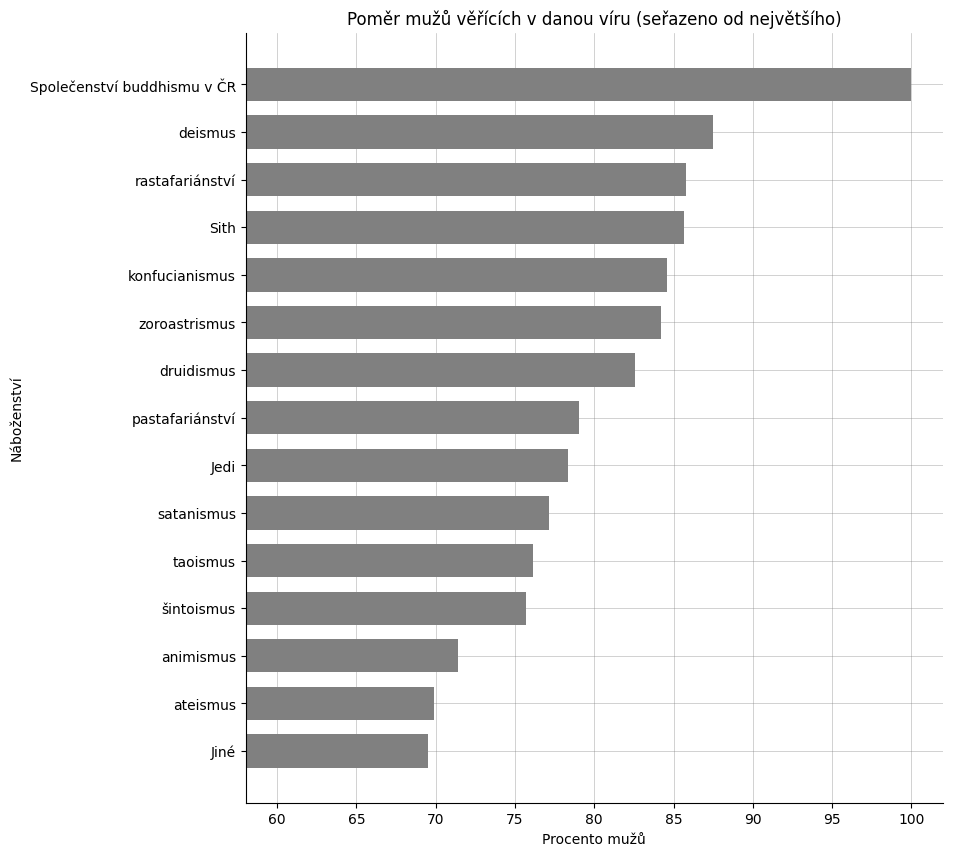

In [125]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter


# Funkce pro formátování s čárkami
def thousand_separator(x, pos):
    return "{:,.0f}".format(x)


data = {
    "Náboženství": [
        "Společenství buddhismu v ČR",
        "deismus",
        "rastafariánství",
        "Sith",
        "konfucianismus",
        "zoroastrismus",
        "druidismus",
        "pastafariánství",
        "Jedi",
        "satanismus",
        "taoismus",
        "šintoismus",
        "animismus",
        "ateismus",
        "Jiné",
    ],
    "Muži": [
        100.000000,
        87.500000,
        85.789474,
        85.658915,
        84.615385,
        84.210526,
        82.539683,
        79.005935,
        78.328497,
        77.154309,
        76.106195,
        75.675676,
        71.428571,
        69.909910,
        69.485639,
    ],
}

# Šířka sloupců v histogramu
bar_width = 0.7

# Pozice pro skupiny sloupců
index = np.arange(len(data["Náboženství"]))

# Vytvoření grafu
fig, ax = plt.subplots(figsize=(9, 10))

# Přidání sloupců pro ženy a muže
bar2 = ax.barh(index, data["Muži"], bar_width, color="grey", label="Muži")

# Přidání popisků, legendy a mřížky
ax.set_xlabel("Procento mužů")
ax.set_ylabel("Náboženství")
ax.set_title("Poměr mužů věřících v danou víru (seřazeno od největšího)")
ax.yaxis.set_ticks(np.arange(0, 15, 1))
ax.set_yticklabels(data["Náboženství"])

# Přidání horizontálních mřížkových čar
ax.grid(axis="y", linestyle="-", color="grey", linewidth=0.5, alpha=0.5)
ax.grid(axis="x", linestyle="-", color="grey", linewidth=0.5, alpha=0.5)
ax.set_axisbelow(True)  # Nastavení mřížky na pozadí
plt.gca().invert_yaxis()  # Invert y axis to have the largest group on top
ax.set_xlim([58, 102])
ax.set_xticks([60, 70, 80, 90, 100], ['60', '70', '80', '90', '100'], minor=True)  # Custom x-axis scale units

# Odstranění ohraničení grafu
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# Zobrazení grafu
plt.show()

In [126]:
# Nahrazení 'cesta_k_souboru.csv' cestou k vašemu CSV souboru
data = pd.read_csv('../data_original/sldb2021_vyjizdka_pracoviste_prostredek_pohlavi.csv')

# Filtrujeme data pro území 'Česká republika'
filtered_data = data[data['uzemi_txt'] == 'Česká republika']

# Seskupíme data podle typu náboženství a pohlaví, a spočítáme součet věřících
grouped_data = filtered_data.groupby(['prostredek_txt', 'pohlavi_txt'])['hodnota'].sum().unstack(fill_value=0)

# Přidáme sloupec pro celkový počet věřících
grouped_data['Celkem'] = grouped_data.sum(axis=1)

# Seřadíme náboženství podle celkového počtu věřících sestupně a vezmeme prvních 15
top_religions = grouped_data.sort_values(by='Celkem', ascending=False).head(15)

# Přejmenování sloupců pro lepší čitelnost
top_religions.columns = ['Muži', 'Ženy', 'Celkem']

print(top_religions[['Celkem', 'Muži', 'Ženy']])

                             Celkem     Muži    Ženy
prostredek_txt                                      
Automobil - řidič           1874806  1122558  752248
Městská hromadná doprava     530890   201869  329021
Žádný (pouze pěšky)          356109   127179  228930
Nezjištěno                   224508   131337   93171
Autobus (kromě MHD)          199755    71732  128023
Automobil - spolucestující   182918    65843  117075
Jízdní kolo                  133629    81480   52149
Vlak                         116155    57609   58546
Jiný dopravní prostředek      15459     9942    5517
Motocykl                       8415     7183    1232


/tmp/ipykernel_2838/2021894885.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data_original/sldb2021_vyjizdka_pracoviste_prostredek_pohlavi.csv')


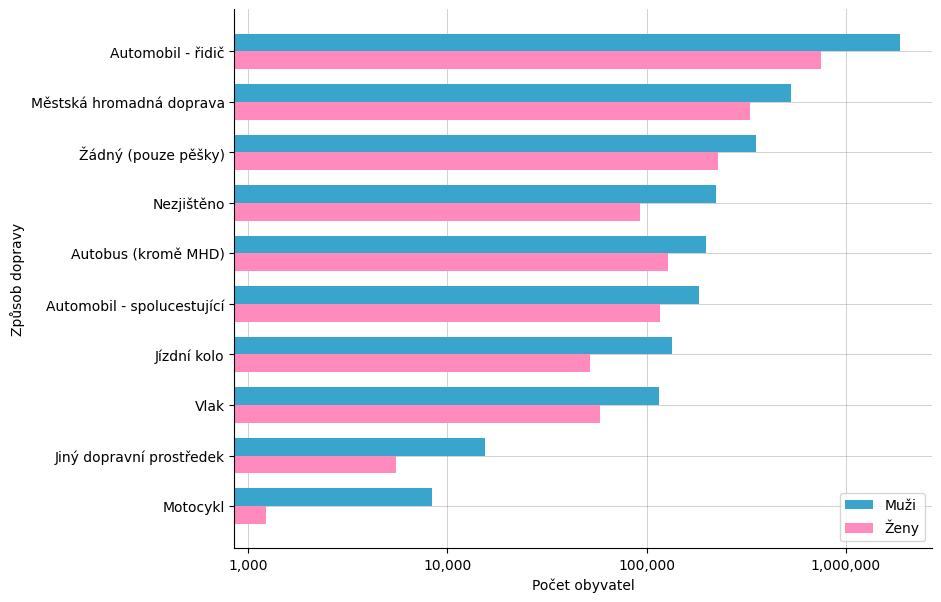

In [43]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter


# Funkce pro formátování s čárkami
def thousand_separator(x, pos):
    return "{:,.0f}".format(x)

data = {
    "Náboženství": [
        "Automobil - řidič",
        "Městská hromadná doprava",
        "Žádný (pouze pěšky)",
        "Nezjištěno",
        "Autobus (kromě MHD)",
        "Automobil - spolucestující",
        "Jízdní kolo",
        "Vlak",
        "Jiný dopravní prostředek",
        "Motocykl",
    ],
    "Muži": [
        1874806,
        530890,
        356109,
        224508,
        199755,
        182918,
        133629,
        116155,
        15459,
        8415,
    ],
    "Ženy": [752248, 329021, 228930, 93171, 128023, 117075, 52149, 58546, 5517, 1232],
}

# Šířka sloupců v histogramu
bar_width = 0.35

# Pozice pro skupiny sloupců
index = np.arange(len(data["Náboženství"]))

# Vytvoření grafu
fig, ax = plt.subplots(figsize=(9, 7))

# Přidání sloupců pro ženy a muže
bar2 = ax.barh(
    index - bar_width / 2, data["Muži"], bar_width, color="#39a5cc", label="Muži"
)
bar1 = ax.barh(
    index + bar_width / 2, data["Ženy"], bar_width, color="#ff8abb", label="Ženy"
)

# Přidání popisků, legendy a mřížky
ax.set_xlabel("Počet obyvatel")
ax.set_ylabel("Způsob dopravy")
# ax.set_title("Počet obyvatel podle způsobu dopravy do zaměstnání")
ax.yaxis.set_ticks(np.arange(0, 10, 1))
ax.set_yticklabels(data["Náboženství"])
ax.legend()

# Přidání horizontálních mřížkových čar
ax.grid(axis="y", linestyle="-", color="grey", linewidth=0.5, alpha=0.5)
ax.grid(axis="x", linestyle="-", color="grey", linewidth=0.5, alpha=0.5)
ax.set_axisbelow(True)  # Nastavení mřížky na pozadí
plt.xscale("log")
# ax.set_xticks([], minor=True)
ax.set_xticks(
    [100000, 1000000], ["100 000", "1 000 000"], minor=True
)  # Custom x-axis scale units
plt.gca().invert_yaxis()  # Invert y axis to have the largest group on top
ax.xaxis.set_major_formatter(FuncFormatter(thousand_separator))

# Odstranění ohraničení grafu
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# Přidání rozšířené legendy s dodatečným textem
legend = ax.legend()
legend._legend_box.align = "left"
legend._legend_box.sep = 10  # nastavení mezery mezi položkami

# Zobrazení grafu
plt.show()

In [134]:
# Nahrazení 'cesta_k_souboru.csv' cestou k vašemu CSV souboru
data = pd.read_csv('../data_original/sldb2021_vyjizdka_skola_prostredek_pohlavi.csv')

# Filtrujeme data pro území 'Česká republika'
filtered_data = data[data['uzemi_txt'] == 'Česká republika']

# Seskupíme data podle typu náboženství a pohlaví, a spočítáme součet věřících
grouped_data = filtered_data.groupby(['prostredek_txt', 'pohlavi_txt'])['hodnota'].sum().unstack(fill_value=0)

# Přidáme sloupec pro celkový počet věřících
grouped_data['Celkem'] = grouped_data.sum(axis=1)

# Seřadíme náboženství podle celkového počtu věřících sestupně a vezmeme prvních 15
top_religions = grouped_data.sort_values(by='Celkem', ascending=False).head(15)

# Přejmenování sloupců pro lepší čitelnost
top_religions.columns = ['Muži', 'Ženy', 'Celkem']

print(top_religions[['Celkem', 'Muži', 'Ženy']])

                            Celkem    Muži    Ženy
prostredek_txt                                    
Nezjištěno                  499187  253700  245487
Žádný (pouze pěšky)         248120  126371  121749
Autobus (kromě MHD)         215399  107376  108023
Městská hromadná doprava    192188   94873   97315
Automobil - spolucestující  155409   78372   77037
Vlak                         89033   41217   47816
Automobil - řidič            20344   11724    8620
Jízdní kolo                   7200    5028    2172
Jiný dopravní prostředek      3335    1775    1560
Motocykl                       684     589      95


/tmp/ipykernel_2838/468242678.py:2: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../data_original/sldb2021_vyjizdka_skola_prostredek_pohlavi.csv')


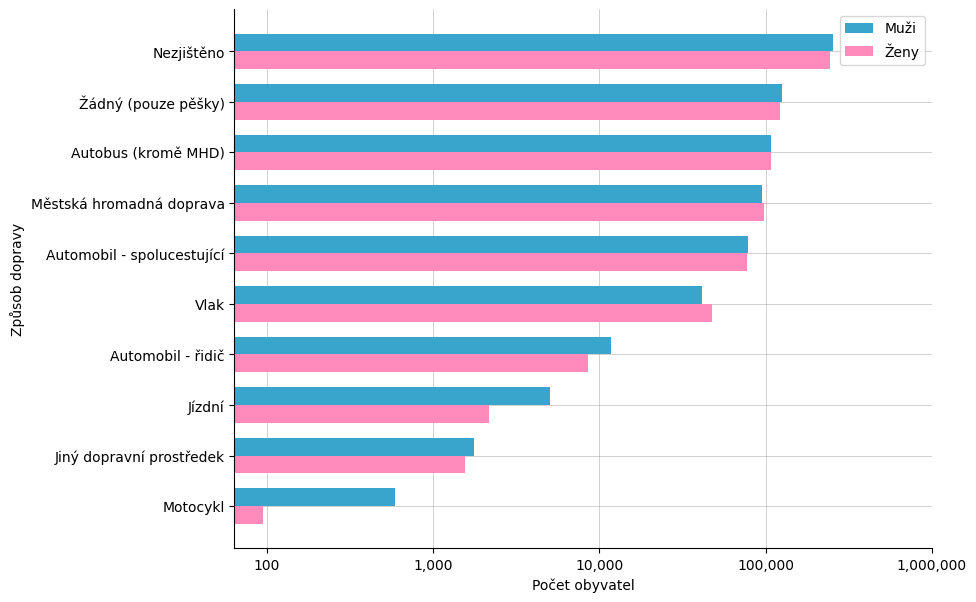

In [44]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter


# Funkce pro formátování s čárkami
def thousand_separator(x, pos):
    return "{:,.0f}".format(x)


data = {
    "Náboženství": [
        "Nezjištěno",
        "Žádný (pouze pěšky)",
        "Autobus (kromě MHD)",
        "Městská hromadná doprava",
        "Automobil - spolucestující",
        "Vlak",
        "Automobil - řidič",
        "Jízdní",
        "Jiný dopravní prostředek",
        "Motocykl",
    ],
    "Muži": [
        253700,
        126371,
        107376,
        94873,
        78372,
        41217,
        11724,
        5028,
        1775,
        589,
    ],
    "Ženy": [245487, 121749, 108023, 97315, 77037, 47816, 8620, 2172, 1560, 95],
}

# Šířka sloupců v histogramu
bar_width = 0.35

# Pozice pro skupiny sloupců
index = np.arange(len(data["Náboženství"]))

# Vytvoření grafu
fig, ax = plt.subplots(figsize=(9, 7))

# Přidání sloupců pro ženy a muže
bar2 = ax.barh(
    index - bar_width / 2, data["Muži"], bar_width, color="#39a5cc", label="Muži"
)
bar1 = ax.barh(
    index + bar_width / 2, data["Ženy"], bar_width, color="#ff8abb", label="Ženy"
)

# Přidání popisků, legendy a mřížky
ax.set_xlabel("Počet obyvatel")
ax.set_ylabel("Způsob dopravy")
# ax.set_title("Počet obyvatel podle způsobu dopravy do školy")
ax.yaxis.set_ticks(np.arange(0, 10, 1))
ax.set_yticklabels(data["Náboženství"])
ax.legend()

# Přidání horizontálních mřížkových čar
ax.grid(axis="y", linestyle="-", color="grey", linewidth=0.5, alpha=0.5)
ax.grid(axis="x", linestyle="-", color="grey", linewidth=0.5, alpha=0.5)
ax.set_axisbelow(True)  # Nastavení mřížky na pozadí
plt.xscale("log")
# ax.set_xticks([], minor=True)
ax.set_xticks(
    [100000, 1000000], ["100 000", "1 000 000"], minor=True
)  # Custom x-axis scale units
plt.gca().invert_yaxis()  # Invert y axis to have the largest group on top
ax.xaxis.set_major_formatter(FuncFormatter(thousand_separator))

# Odstranění ohraničení grafu
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# Přidání rozšířené legendy s dodatečným textem
legend._legend_box.align = "left"
legend._legend_box.sep = 10  # nastavení mezery mezi položkami

# Zobrazení grafu
plt.show()

# Nezaměstnanost

In [36]:
import json
import pandas as pd

# Načtení JSON s počtem obyvatel obcí
with open('data/kraje_nazev_pocet.json') as f:
    kraje_pocty = json.load(f)['kraje_nazev_pocet']

# Nahrazení 'cesta_k_souboru.csv' cestou k vašemu CSV souboru
data = pd.read_csv('../data_original/sldb2021_aktivita_vek1_pohlavi.csv')

# Filtrujeme data pro území 'Česká republika', kde 'aktivita_txt' je 'Nezaměstnaní'
filtered_data = data[(data['uzemi_cis'] == 100) & (data['aktivita_txt'] == 'Nezaměstnaní') & (data['pohlavi_txt'].isnull())]

# Seskupíme data podle kraje a spočítáme součet nezaměstnaných
grouped_data = filtered_data.groupby('uzemi_txt')['hodnota'].sum()

# Vypočítáme poměr nezaměstnaných v každém kraji
pomer_nezamestnanych = grouped_data / grouped_data.index.map(kraje_pocty).astype(float) * 100

pomer_nezamestnanych = pomer_nezamestnanych.sort_values(ascending=False)

# Vytiskneme poměr nezaměstnaných v každém kraji
print(pomer_nezamestnanych)

uzemi_txt
Karlovarský kraj        4.193076
Ústecký kraj            3.896601
Moravskoslezský kraj    3.466596
Liberecký kraj          2.666238
Olomoucký kraj          2.608957
Jihomoravský kraj       2.566023
Hlavní město Praha      2.508314
Středočeský kraj        2.234463
Plzeňský kraj           2.158793
Zlínský kraj            2.141828
Jihočeský kraj          2.115533
Královéhradecký kraj    2.000546
Kraj Vysočina           1.877181
Pardubický kraj         1.868688
dtype: float64


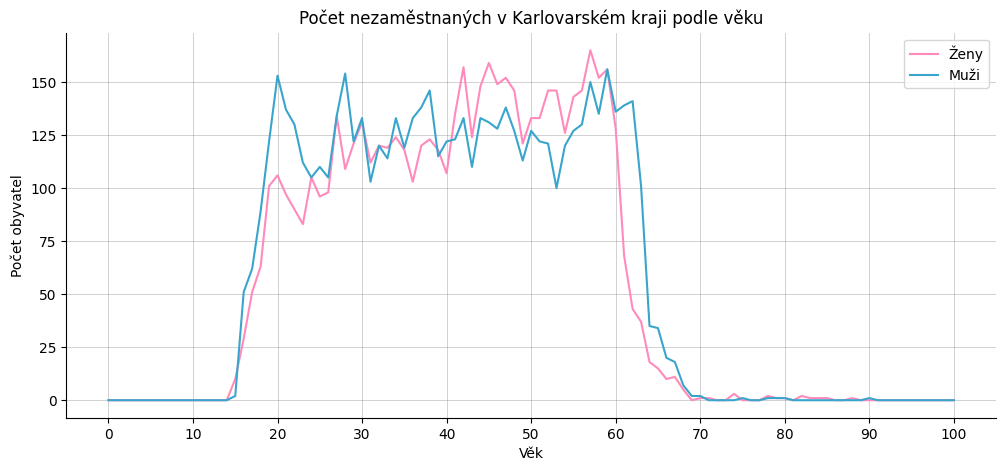

In [9]:
# Věkové kategorie a data
age_groups = np.arange(0, 101, 1)
women_counts = [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 29, 51, 63, 101, 106, 97, 90, 83, 105, 96, 98, 134, 109, 121, 131, 112, 120, 119, 124, 118, 103, 120, 123, 118, 107, 135, 157, 124, 148, 159, 149, 152, 146, 121, 133, 133, 146, 146, 126, 143, 146, 165, 152, 156, 128, 68, 43, 37, 18, 15, 10, 11, 5, 0, 1, 1, 0, 0, 3, 0, 0, 0, 2, 1, 1, 0, 2, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,]
men_counts = [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 51, 62, 89, 122, 153, 137, 130, 112, 105, 110, 105, 134, 154, 122, 133, 103, 120, 114, 133, 119, 133, 138, 146, 115, 122, 123, 133, 110, 133, 131, 128, 138, 127, 113, 127, 122, 121, 100, 120, 127, 130, 150, 135, 156, 136, 139, 141, 101, 35, 34, 20, 18, 7, 2, 2, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,]

# Vytvoření grafu
fig, ax = plt.subplots(figsize=(12, 5))

# Přidání spojnic pro ženy a muže
ax.plot(age_groups, women_counts, label="Ženy", color="#ff8abb")
ax.plot(age_groups, men_counts, label="Muži", color="#39a5cc")

# Přidání popisků, legendy a mřížky
ax.set_xlabel("Věk")
ax.set_ylabel("Počet obyvatel")
ax.set_title("Počet nezaměstnaných v Karlovarském kraji podle věku")
ax.set_xticks(np.arange(len(age_groups)))
ax.set_xticklabels(age_groups)
ax.legend()

# Přidání horizontálních mřížkových čar
ax.grid(axis="y", linestyle="-", color="grey", linewidth=0.5, alpha=0.5)
ax.grid(axis="x", linestyle="-", color="grey", linewidth=0.5, alpha=0.5)
ax.set_axisbelow(True)  # Nastavení mřížky na pozadí

# Zvýraznění popisku pro skupinu '60-64' tučně
# ax.get_xticklabels()[12].set_weight('bold')

# Přidání horizontální čáry na úrovni 50%, omezené na rozsah dat
# ax.vlines(x=15, ymin=-5, ymax=160, colors='#404040', linestyles='--', linewidth=1)

# ax.set_yscale('log')
ax.set_xticks(
    [0,10,20,30,40,50,60,70,80,90,100], minor=False
)  # Custom x-axis scale units

# Odstranění ohraničení grafu
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines["left"].set_visible(False)
# ax.spines["bottom"].set_visible(False)

# Zobrazení grafu
plt.show()

In [45]:
import json
import pandas as pd

# Načtení JSON s počtem obyvatel obcí
with open('data/kraje_nazev_pocet.json') as f:
    kraje_pocty = json.load(f)['kraje_nazev_pocet']

# Nahrazení 'cesta_k_souboru.csv' cestou k vašemu CSV souboru
data = pd.read_csv('../data_original/sldb2021_aktivita_vek1_pohlavi.csv')

# Filtrujeme data pro území 'Česká republika', kde 'aktivita_txt' je 'Nezaměstnaní'
filtered_data = data[(data['uzemi_cis'] == 100) & (data['aktivita_txt'] == 'Nezaměstnaní') & (data['pohlavi_txt'].isnull() == False)]

filtered_data = filtered_data.groupby(['uzemi_txt', 'pohlavi_txt'])['hodnota'].sum()

# Seskupíme data podle kraje a spočítáme součet nezaměstnaných
grouped_data = filtered_data

# Vypočítáme poměr nezaměstnaných v každém kraji
pomer_nezamestnanych = grouped_data / grouped_data.index.get_level_values('uzemi_txt').map(kraje_pocty).astype(float) * 100

# Vytiskneme poměr nezaměstnaných v každém kraji
print(pomer_nezamestnanych)


# # Seskupíme data podle typu náboženství a pohlaví, a spočítáme součet věřících
# grouped_data = filtered_data.groupby(['prostredek_txt', 'pohlavi_txt'])['hodnota'].sum().unstack(fill_value=0)

# # Přidáme sloupec pro celkový počet věřících
# grouped_data['Celkem'] = grouped_data.sum(axis=1)

# # Seřadíme náboženství podle celkového počtu věřících sestupně a vezmeme prvních 15
# top_religions = grouped_data.sort_values(by='Celkem', ascending=False).head(15)

# # Přejmenování sloupců pro lepší čitelnost
# top_religions.columns = ['Muži', 'Ženy', 'Celkem']

# print(top_religions[['Celkem', 'Muži', 'Ženy']])

uzemi_txt             pohlavi_txt
Hlavní město Praha    muž            1.235946
                      žena           1.272368
Jihomoravský kraj     muž            1.278753
                      žena           1.287270
Jihočeský kraj        muž            1.037823
                      žena           1.077709
Karlovarský kraj      muž            2.159776
                      žena           2.033300
Kraj Vysočina         muž            0.903627
                      žena           0.973554
Královéhradecký kraj  muž            1.036219
                      žena           0.964327
Liberecký kraj        muž            1.298654
                      žena           1.367584
Moravskoslezský kraj  muž            1.808502
                      žena           1.658094
Olomoucký kraj        muž            1.342394
                      žena           1.266562
Pardubický kraj       muž            0.930521
                      žena           0.938167
Plzeňský kraj         muž            1.078365


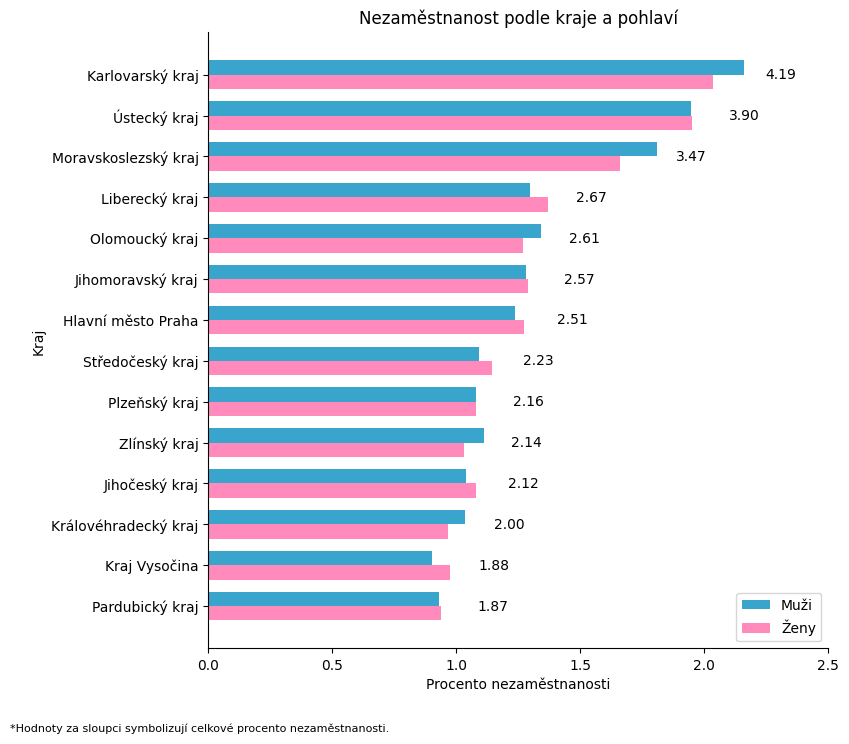

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Data předaná uživatelem
data = {
    "Náboženství": [
        "Karlovarský kraj", "Ústecký kraj", "Moravskoslezský kraj", "Liberecký kraj",
        "Olomoucký kraj", "Jihomoravský kraj", "Hlavní město Praha", "Středočeský kraj",
        "Plzeňský kraj", "Zlínský kraj", "Jihočeský kraj", "Královéhradecký kraj",
        "Kraj Vysočina", "Pardubický kraj"
    ],
    "Muži": [
        2.159776, 1.947667, 1.808502, 1.298654, 1.342394, 1.278753, 1.235946, 1.092858,
        1.078365, 1.112113, 1.037823, 1.036219, 0.903627, 0.930521
    ],
    "Ženy": [
        2.0333, 1.948934, 1.658094, 1.367584, 1.266562, 1.28727, 1.272368, 1.141605,
        1.080428, 1.029715, 1.077709, 0.964327, 0.973554, 0.938167
    ],
}

# Šířka sloupců v histogramu
bar_width = 0.35

# Pozice pro skupiny sloupců
index = np.arange(len(data["Náboženství"]))

# Vytvoření grafu
fig, ax = plt.subplots(figsize=(8, 8))

# Přidání sloupců pro ženy a muže
bar1 = ax.barh(
    index - bar_width / 2, data["Muži"], bar_width, color="#39a5cc", label="Muži"
)
bar2 = ax.barh(
    index + bar_width / 2, data["Ženy"], bar_width, color="#ff8abb", label="Ženy"
)

# Přidání popisků, legendy a mřížky
ax.set_xlabel("Procento nezaměstnanosti")
ax.set_ylabel("Kraj")
ax.set_title("Nezaměstnanost podle kraje a pohlaví")
ax.yaxis.set_ticks(index)
ax.set_yticklabels(data["Náboženství"])
ax.legend()

# Přidání textu s celkovými hodnotami
for i in range(len(data["Náboženství"])):
    total = data["Muži"][i] + data["Ženy"][i]
    ax.text((total / 2) + 0.15, i, f'{total:.2f}', va='center')

ax.text(-0.8, 16, '*Hodnoty za sloupci symbolizují celkové procento nezaměstnanosti.', va='center',  fontdict={'size'   : 8})

# Přidání mřížkových čar a nastavení grafu
# ax.grid(axis="y", linestyle="-", color="grey", linewidth=0.5, alpha=0.5)
plt.gca().invert_yaxis()  # Invert y axis to have the largest group on top
ax.set_xlim([0.0, 2.5])

# Odstranění ohraničení grafu
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Zobrazení grafu
plt.show()


# Státní občanství

In [ ]:
# Načtení JSON s počtem obyvatel obcí
# with open('data/kraje_nazev_pocet.json') as f:
#     kraje_pocty = json.load(f)['kraje_nazev_pocet']

import json
import pandas as pd

# Nahrazení 'cesta_k_souboru.csv' cestou k vašemu CSV souboru
data = pd.read_csv('../data_original/sldb2021_obcanstvi.csv')

# Filtrování dat
filtered_data = data[data['uzemi_txt'] == 'Česká republika']

In [7]:
# Export výsledného datasetu do nového CSV souboru
filtered_data.to_csv('../data_original/sldb2021_obcanstvi_cr.csv', index=False)

In [29]:
# Zjištění celkového počtu obyvatel (řádek s prázdnou hodnotou uzemi_txt)
total_population_row = filtered_data[filtered_data['obcanstvi_txt'].isna()]
total_population = total_population_row['hodnota'].values[0]

# Seřazení podle hodnoty 'pocet' od největší po nejmenší
sorted_data = filtered_data.sort_values(by='hodnota', ascending=True)

# Odebrání řádku s prázdnou hodnotou 'obcanstvi_txt'
sorted_data = sorted_data[sorted_data['obcanstvi_txt'].notna()]

# Výběr 10 nejvyšších hodnot
top_10 = sorted_data.head(10)

# Vypočítání procentuálního podílu z celkového počtu obyvatel
top_10['percent'] = (top_10['hodnota'] / total_population) * 100

# Výpis výsledků
print("Top 10 hodnot a jejich procentuální podíl z celkového počtu obyvatel:")
print(top_10[['obcanstvi_txt', 'hodnota', 'percent']])

Top 10 hodnot a jejich procentuální podíl z celkového počtu obyvatel:
                                             obcanstvi_txt  hodnota  percent
1199030             Korejská lidově demokratická republika        1  0.00001
1199042  Zvláštní administrativní oblast Čínské lidové ...        1  0.00001
1198964                                             Belize        1  0.00001
1199049                     Mauritánská islámská republika        1  0.00001
1199062                                  Republika Vanuatu        1  0.00001
1198959                               Bhútánské království        1  0.00001
1198957                                           Barbados        1  0.00001
1199120                               Nezávislý stát Samoa        1  0.00001
1199059                                    Republika Nauru        1  0.00001
1198980                                      Komorský svaz        1  0.00001


/tmp/ipykernel_388/745144761.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10['percent'] = (top_10['hodnota'] / total_population) * 100


In [28]:
# Filtrování řádků pro okresy
district_data = data[(data['uzemi_cis'] == 43) & (data['obcanstvi_txt'].notna())]

# Skupinové agregace pro zjištění celkového počtu obyvatel v každém okrese
total_per_district = district_data.groupby('uzemi_txt')['hodnota'].sum()

# Filtrování dat pro občanství "Česká republika" a skupinové agregace pro zjištění počtu obyvatel s českým občanstvím
cz_per_district = district_data[district_data['obcanstvi_txt'] == 'Česká republika'].groupby('uzemi_txt')['hodnota'].sum()

# Vypočítání procentuálního podílu
percent_cz = (cz_per_district / total_per_district) * 100

# Odebrání řádku s prázdnou hodnotou 'obcanstvi_txt'
percent_cz = percent_cz.sort_values(ascending=False)

# Výpis výsledků
print("Procentuální podíl obyvatel s českým občanstvím v každé obci:")
print(percent_cz)

Procentuální podíl obyvatel s českým občanstvím v každé obci:
uzemi_txt
Vilice              100.000000
Stehlovice          100.000000
Pohnání             100.000000
Pohnánec            100.000000
Medonosy            100.000000
                       ...    
Semice               74.390244
Potůčky              71.573604
Hřensko              69.196429
Strážný              63.376623
Kryštofovy Hamry     58.641975
Name: hodnota, Length: 5344, dtype: float64


# Zaměstnání - odvětví

In [ ]:
import json
import pandas as pd

# Nahrazení 'cesta_k_souboru.csv' cestou k vašemu CSV souboru
data = pd.read_csv('../data_original/sldb2021_odvetvi_pohlavi.csv')

# Filtrování dat
filtered_data = data[data['uzemi_txt'] == 'Česká republika']

In [ ]:
# Zjištění celkového počtu obyvatel (řádek s prázdnou hodnotou uzemi_txt)
total_population_row = filtered_data[filtered_data['pohlavi_txt'].isna()]
total_population = total_population_row['hodnota'].values[0]

# Seřazení podle hodnoty 'pocet' od největší po nejmenší
sorted_data = filtered_data.sort_values(by='hodnota', ascending=True)

# Odebrání řádku s prázdnou hodnotou 'obcanstvi_txt'
sorted_data = sorted_data[sorted_data['obcanstvi_txt'].notna()]

# Výběr 10 nejvyšších hodnot
top_10 = sorted_data.head(10)

# Vypočítání procentuálního podílu z celkového počtu obyvatel
top_10['percent'] = (top_10['hodnota'] / total_population) * 100

# Výpis výsledků
print("Top 10 hodnot a jejich procentuální podíl z celkového počtu obyvatel:")
print(top_10[['obcanstvi_txt', 'hodnota', 'percent']])

# Nezaměstnaní ČR

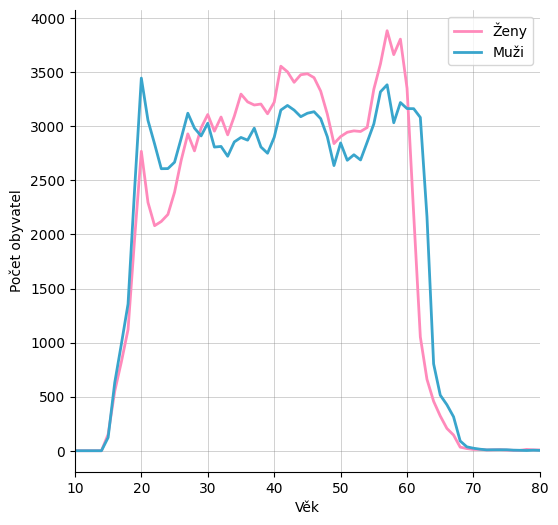

In [23]:
# Věkové kategorie a data
age_groups = np.arange(0, 101, 1)
women_counts = [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 151, 552, 823, 1121, 1970, 2769, 2296, 2081, 2120, 2185, 2390, 2686, 2930, 2773, 2986, 3109, 2955, 3086, 2921, 3094, 3298, 3226, 3197, 3206, 3116, 3222, 3556, 3504, 3407, 3477, 3486, 3450, 3325, 3112, 2840, 2905, 2945, 2958, 2952, 2989, 3343, 3578, 3884, 3663, 3806, 3352, 2188, 1052, 660, 457, 321, 206, 145, 33, 20, 12, 12, 7, 8, 10, 6, 4, 3, 12, 8, 7, 4, 4, 3, 3, 1, 3, 4, 3, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1]
men_counts = [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 122, 631, 988, 1357, 2430, 3446, 3055, 2836, 2608, 2609, 2668, 2889, 3121, 2983, 2911, 3029, 2808, 2814, 2723, 2856, 2897, 2872, 2983, 2809, 2751, 2898, 3150, 3193, 3150, 3089, 3121, 3135, 3071, 2903, 2637, 2846, 2686, 2737, 2689, 2854, 3022, 3319, 3384, 3033, 3220, 3164, 3163, 3082, 2164, 803, 514, 425, 314, 90, 36, 23, 14, 8, 9, 9, 9, 5, 4, 2, 5, 3, 1, 2, 0, 1, 3, 3, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]

# Vytvoření grafu
fig, ax = plt.subplots(figsize=(6, 6))

# Přidání spojnic pro ženy a muže
ax.plot(age_groups, women_counts, label="Ženy", linewidth=2,color="#ff8abb")
ax.plot(age_groups, men_counts, label="Muži", linewidth=2,color="#39a5cc")

# Přidání popisků, legendy a mřížky
ax.set_xlabel("Věk")
ax.set_ylabel("Počet obyvatel")
# ax.set_title("Počet nezaměstnaných v ČR podle věku")
ax.set_xticks(np.arange(len(age_groups)))
ax.set_xticklabels(age_groups)
ax.legend()

# Přidání horizontálních mřížkových čar
ax.grid(axis="y", linestyle="-", color="grey", linewidth=0.5, alpha=0.5)
ax.grid(axis="x", linestyle="-", color="grey", linewidth=0.5, alpha=0.5)
ax.set_axisbelow(True)  # Nastavení mřížky na pozadí

# Zvýraznění popisku pro skupinu '60-64' tučně
# ax.get_xticklabels()[12].set_weight('bold')

# Přidání horizontální čáry na úrovni 50%, omezené na rozsah dat
# ax.vlines(x=15, ymin=-5, ymax=160, colors='#404040', linestyles='--', linewidth=1)

# ax.set_yscale('log')
ax.set_xticks(
    [0,10,20,30,40,50,60,70,80,90,100], minor=False
)  # Custom x-axis scale units

# Odstranění ohraničení grafu
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines["left"].set_visible(False)
# ax.spines["bottom"].set_visible(False)

ax.set_xlim(10, 80)

# Zobrazení grafu
plt.show()

# Vzdelani - velikost obce

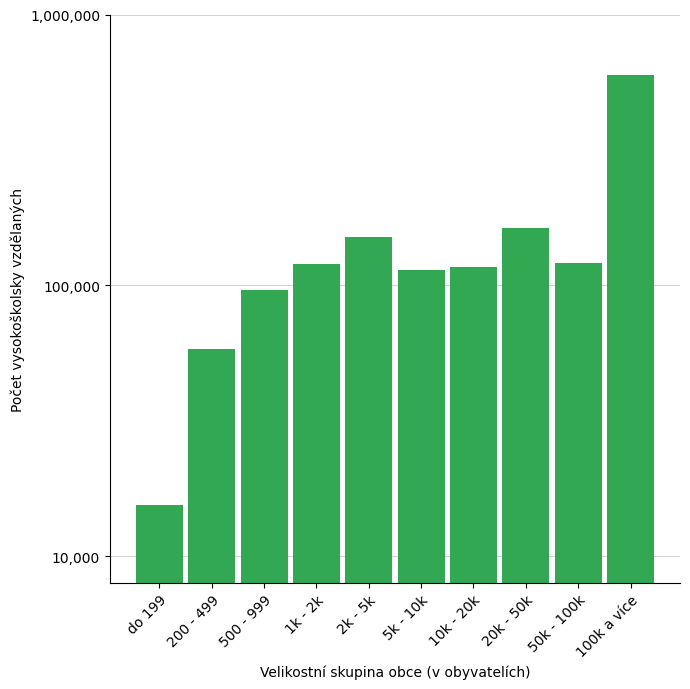

In [37]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter

# Funkce pro formátování s čárkami
def thousand_separator(x, pos):
    return '{:,.0f}'.format(x)

# Adjust the histogram to remove gaps between bars

# Věkové kategorie a data
age_groups = [ 'do 199', '200 - 499', '500 - 999', '1k - 2k', '2k - 5k', '5k - 10k', '10k - 20k', '20k - 50k', '50k - 100k', '100k a více']
counts = [15500, 58397, 96158, 120494, 150960, 114322, 116716, 162702, 121484, 595674]

# Výpočet celkového počtu obyvatel
total_population = sum(counts)

# Šířka sloupců v histogramu
bar_width = 0.35

# Pozice pro skupiny sloupců
index = np.arange(len(age_groups))

# Vytvoření grafu
fig, ax = plt.subplots(figsize=(7, 7))

# Přidání sloupců bez mezer (bar width set to 1)
bar1 = ax.bar(index, counts, 0.9, color='#32a852', label=f'Celkový počet - {total_population:,}')

# Přidání popisků, legendy a mřížky
ax.set_xlabel('Velikostní skupina obce (v obyvatelích)')
ax.set_ylabel('Počet vysokoškolsky vzdělaných')
ax.set_xticks(index)
ax.set_xticklabels(age_groups, rotation=45, ha='right', rotation_mode='anchor')
# ax.legend()

# Přidání horizontálních mřížkových čar
ax.grid(axis='y', linestyle='-', color='grey', linewidth=0.5, alpha=0.5)
ax.set_axisbelow(True)  # Nastavení mřížky na pozadí

# Odstranění ohraničení grafu
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

ax.set_ylim(8000, 1000000)
ax.set_yscale('log')
ax.set_yticks([10000, 100000, 1000000], ['10 000', '100 000', '1 000 000'], minor=True)  # Custom x-axis scale units
ax.yaxis.set_major_formatter(FuncFormatter(thousand_separator)) 

# Zobrazení grafu
plt.tight_layout()
plt.show()


In [ ]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter

# Funkce pro formátování s čárkami
def thousand_separator(x, pos):
    return '{:,.0f}'.format(x)

data = {
    'Náboženství': [
        'Bez náboženské víry', 'Neuvedeno', 'věřící - nehlásící se k žádné církvi/nábož. spol.',
        'Církev římskokatolická', 'katolická víra (katolík)', 'křesťanství',
        'věřící - hlásící se k neuvedené církvi', 'Pravoslavná církev v českých zemích',
        'Českobratrská církev evangelická', 'protestantská/evangelická víra',
        'Církev československá husitská', 'Jiné', 'Jedi',
        'Náboženská společnost Svědkové Jehovovi', 'Církev bratrská'
    ],
    'Muži': [2548297, 1597650, 428890, 319472, 97797, 31638, 29469, 19974, 14241, 11346, 9387, 14806, 16467, 5548, 4958],
    'Ženy': [2478844, 1564890, 531311, 421547, 138037, 39451, 36098, 20707, 18336, 15803, 14223, 6502, 4556, 7750, 5804]
}

# Šířka sloupců v histogramu
bar_width = 0.35

# Pozice pro skupiny sloupců
index = np.arange(len(data['Náboženství']))

# Vytvoření grafu
fig, ax = plt.subplots(figsize=(9, 10))

# Přidání sloupců pro ženy a muže
bar1 = ax.barh(index - bar_width/2, data['Ženy'], bar_width, color='#ff8abb', label='Ženy')
bar2 = ax.barh(index + bar_width/2, data['Muži'], bar_width, color='#39a5cc', label='Muži')

# Přidání popisků, legendy a mřížky
ax.set_xlabel('Počet obyvatel')
ax.set_ylabel('Náboženství')
ax.set_title('Počet obyvatel podle náboženství')
ax.yaxis.set_ticks(np.arange(0, 15, 1))
ax.set_yticklabels(data['Náboženství'])
ax.legend()

# Přidání horizontálních mřížkových čar
ax.grid(axis='y', linestyle='-', color='grey', linewidth=0.5, alpha=0.5)
ax.grid(axis='x', linestyle='-', color='grey', linewidth=0.5, alpha=0.5)
ax.set_axisbelow(True)  # Nastavení mřížky na pozadí
plt.xscale('log')
# ax.set_xticks([], minor=True)
ax.set_xticks([100000, 1000000], ['100 000', '1 000 000'], minor=True)  # Custom x-axis scale units
plt.gca().invert_yaxis()  # Invert y axis to have the largest group on top
ax.xaxis.set_major_formatter(FuncFormatter(thousand_separator)) 

# Odstranění ohraničení grafu
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# Přidání rozšířené legendy s dodatečným textem
legend._legend_box.align = "left"
legend._legend_box.sep = 10  # nastavení mezery mezi položkami

# Zobrazení grafu
plt.show()

# Státní občanství 2

In [8]:
# Načtení JSON s počtem obyvatel obcí
# with open('data/kraje_nazev_pocet.json') as f:
#     kraje_pocty = json.load(f)['kraje_nazev_pocet']

import json
import pandas as pd

# Nahrazení 'cesta_k_souboru.csv' cestou k vašemu CSV souboru
data = pd.read_csv('../data_original/sldb2021_obcanstvi.csv')

# Filtrování dat
filtered_data = data[data['uzemi_txt'] == 'Česká republika']

In [49]:
# Export výsledného datasetu do nového CSV souboru
filtered_data.to_csv('../data_original/sldb2021_obcanstvi_cr.csv', index=False)

In [9]:
# Zjištění celkového počtu obyvatel (řádek s prázdnou hodnotou uzemi_txt)
total_population_row = filtered_data[filtered_data['obcanstvi_txt'].isna()]
total_population = total_population_row['hodnota'].values[0]

# Vyloučení řádků, kde 'obcanstvi_txt' == 'Česká republika'
# filtered_data = filtered_data[filtered_data['obcanstvi_txt'] != 'Česká republika']

# Seřazení podle hodnoty 'pocet' od největší po nejmenší
sorted_data = filtered_data.sort_values(by='hodnota', ascending=False)

# Odebrání řádku s prázdnou hodnotou 'obcanstvi_txt'
sorted_data = sorted_data[sorted_data['obcanstvi_txt'].notna()]

# Výběr 10 nejvyšších hodnot
top_10 = sorted_data.head(10)

# Vypočítání procentuálního podílu z celkového počtu obyvatel
top_10['percent'] = (top_10['hodnota'] / total_population) * 100

# Výpis výsledků
print("Top 10 hodnot a jejich procentuální podíl z celkového počtu obyvatel:")
print(top_10[['obcanstvi_txt', 'hodnota', 'percent']])

Top 10 hodnot a jejich procentuální podíl z celkového počtu obyvatel:
                              obcanstvi_txt  hodnota    percent
1198987                     Česká republika  9959190  94.631623
1199110                            Ukrajina   150193   1.427125
1199088                 Slovenská republika    95592   0.908309
1199089  Vietnamská socialistická republika    54186   0.514872
1198945                     Dvojí občanství    45376   0.431160
1199078                      Ruská federace    35279   0.335219
1199124                          Nezjištěno    29137   0.276858
1199074                    Polská republika    14367   0.136514
1198966                 Bulharská republika    10842   0.103020
1199077                            Rumunsko    10125   0.096207


/tmp/ipykernel_234/3062232481.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10['percent'] = (top_10['hodnota'] / total_population) * 100


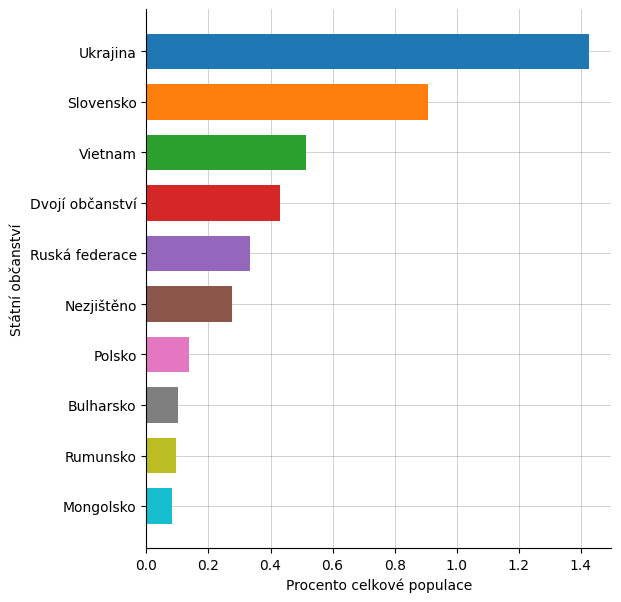

In [68]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter


# Funkce pro formátování s čárkami
def thousand_separator(x, pos):
    return "{:,.0f}".format(x)

data = [
                          'Ukrajina',
               'Slovensko',
'Vietnam',
                   'Dvojí občanství',
                    'Ruská federace',
                        'Nezjištěno',
                  'Polsko',
               'Bulharsko',
                          'Rumunsko',
                         'Mongolsko',
]

values = [
1.427125,
0.908309,
0.514872,
0.431160,
0.335219,
0.276858,
0.136514,
0.103020,
0.096207,
0.081299,
]

# Definování seznamu barev pro každý sloupec
colors = plt.cm.tab10(np.linspace(0, 1, len(data)))

# Šířka sloupců v histogramu
bar_width = 0.7

# Pozice pro skupiny sloupců
index = np.arange(len(data))

# Vytvoření grafu
fig, ax = plt.subplots(figsize=(6, 7))

# Přidání sloupců pro ženy a muže
bar2 = ax.barh(index, values, bar_width, color=colors)

# Přidání popisků, legendy a mřížky
ax.set_xlabel("Procento celkové populace")
ax.set_ylabel("Státní občanství")
# ax.set_title("Poměr mužů věřících v danou víru (seřazeno od největšího)")
ax.yaxis.set_ticks(np.arange(0, 10, 1))
ax.set_yticklabels(data)

# Přidání horizontálních mřížkových čar
ax.grid(axis="y", linestyle="-", color="grey", linewidth=0.5, alpha=0.5)
ax.grid(axis="x", linestyle="-", color="grey", linewidth=0.5, alpha=0.5)
ax.set_axisbelow(True)  # Nastavení mřížky na pozadí
plt.gca().invert_yaxis()  # Invert y axis to have the largest group on top
# ax.set_xlim([58, 102])
# ax.set_xticks([60, 70, 80, 90, 100], ['60', '70', '80', '90', '100'], minor=True)  # Custom x-axis scale units

# Odstranění ohraničení grafu
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# Zobrazení grafu
plt.show()

# Typy zaměstnání

In [86]:
data_ = [
    'Zpracovatelský průmysl',
    'Velkoobchod a maloobchod; opravy a údržba motorových vozidel',
    'Zdravotní a sociální péče',
    'Stavebnictví',
    'Vzdělávání',
    'Veřejná správa a obrana; povinné sociální zabezpečení',
    'Doprava a skladování',
    'Profesní, vědecké a technické činnosti',
    'Administrativní a podpůrné činnosti',
    'Informační a komunikační činnosti'
]

# Načtení JSON s počtem obyvatel obcí
# with open('data/kraje_nazev_pocet.json') as f:
#     kraje_pocty = json.load(f)['kraje_nazev_pocet']

import json
import pandas as pd

# Nahrazení 'cesta_k_souboru.csv' cestou k vašemu CSV souboru
data = pd.read_csv('../data_original/sldb2021_odvetvi_pohlavi.csv')

# Filtrování dat
filtered_data = data[(data['uzemi_txt'] == 'Česká republika') & (data['pohlavi_txt'] == 'žena') & (data['odvetvi_txt'].isin(data_))]

In [87]:
# Seřazení podle hodnoty 'pocet' od největší po nejmenší
sorted_data = filtered_data.sort_values(by='hodnota', ascending=False)

# Výběr 10 nejvyšších hodnot
top_10 = sorted_data.head(10)

# Výpis výsledků
# print("Top 10 hodnot a jejich procentuální podíl z celkového počtu obyvatel:")
print(top_10[['odvetvi_txt', 'hodnota']])

                                              odvetvi_txt  hodnota
437192                             Zpracovatelský průmysl   444220
437234                          Zdravotní a sociální péče   330196
437204  Velkoobchod a maloobchod; opravy a údržba moto...   313102
437231                                         Vzdělávání   287867
437228  Veřejná správa a obrana; povinné sociální zabe...   168554
437222             Profesní, vědecké a technické činnosti   143393
437225                Administrativní a podpůrné činnosti   138319
437207                               Doprava a skladování    77344
437213                  Informační a komunikační činnosti    52968
437201                                       Stavebnictví    35398


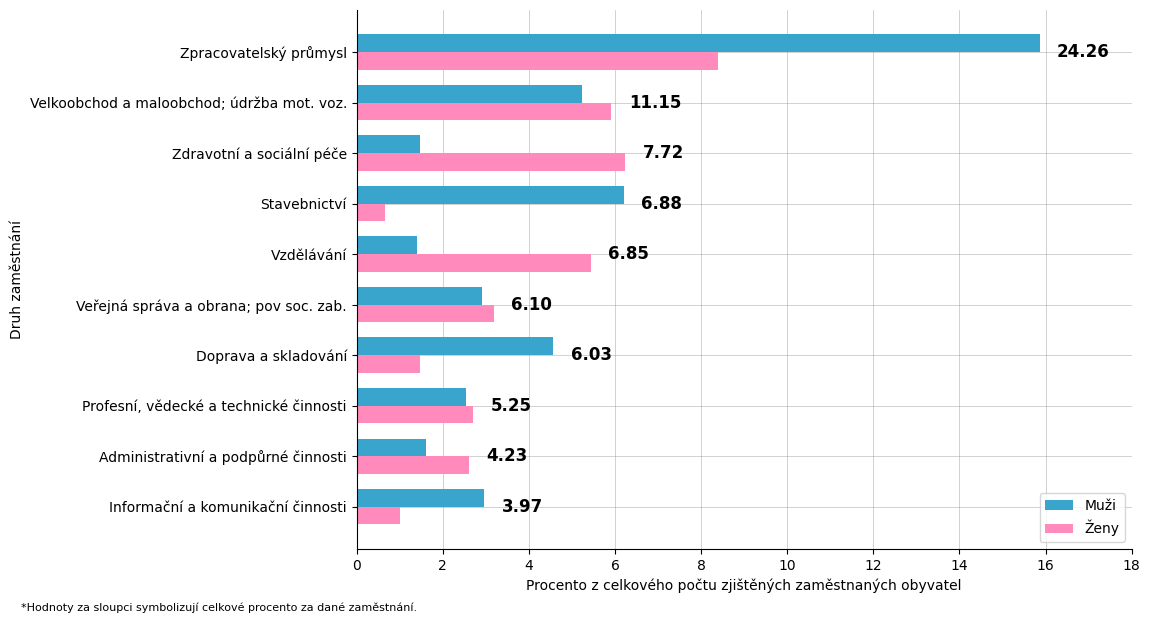

In [9]:
data_text = [
    'Zpracovatelský průmysl',
    'Velkoobchod a maloobchod; údržba mot. voz.',
    'Zdravotní a sociální péče',
    'Stavebnictví',
    'Vzdělávání',
    'Veřejná správa a obrana; pov soc. zab.',
    'Doprava a skladování',
    'Profesní, vědecké a technické činnosti',
    'Administrativní a podpůrné činnosti',
    'Informační a komunikační činnosti'
]

men_counts = [
    (839257 / 5290071) * 100,
    (276645 / 5290071) * 100,
    (78398 / 5290071) * 100,
    (328715 / 5290071) * 100,
    (74352 / 5290071) * 100,
    (154134 / 5290071) * 100,
    (241610 / 5290071) * 100,
    (134136 / 5290071) * 100,
    (85538 / 5290071) * 100,
    (156890 / 5290071) * 100,
]

women_counts = [
    (444220 / 5290071) * 100,
    (313102 / 5290071) * 100,
    (330196 / 5290071) * 100,
    (35398 / 5290071) * 100,
    (287867 / 5290071) * 100,
    (168554 / 5290071) * 100,
    (77344 / 5290071) * 100,
    (143393 / 5290071) * 100,
    (138319 / 5290071) * 100,
    (52968 / 5290071) * 100,
]

# Šířka sloupců v histogramu
bar_width = 0.35

# Pozice pro skupiny sloupců
index = np.arange(len(data_text))

# Vytvoření grafu
fig, ax = plt.subplots(figsize=(10, 7))

# Přidání sloupců pro ženy a muže
bar1 = ax.barh(
    index - bar_width / 2, men_counts, bar_width, color="#39a5cc", label="Muži"
)
bar2 = ax.barh(
    index + bar_width / 2, women_counts, bar_width, color="#ff8abb", label="Ženy"
)

# Přidání popisků, legendy a mřížky
ax.set_xlabel("Procento z celkového počtu zjištěných zaměstnaných obyvatel")
ax.set_ylabel("Druh zaměstnání")
# ax.set_title("Nezaměstnanost podle kraje a pohlaví")
ax.yaxis.set_ticks(index)
ax.set_yticklabels(data_text)
ax.legend()

# Přidání textu s celkovými hodnotami
for i in range(len(data_text)):
    max_ = max([men_counts[i], women_counts[i]])
    total = men_counts[i] + women_counts[i]
    # total = men_counts[i] + women_counts[i]
    ax.text((max_) + 0.4, i, f'{total:.2f}', va='center', fontdict={'weight': 'bold', 'size': 12})

# ax.text((total / 2) + 0.15, i, f'{total:.2f}', va='center')
# ax.text((total / 2) + 0.15, i, f'{total:.2f}', va='center')
# ax.text((total / 2) + 0.15, i, f'{total:.2f}', va='center')
# ax.text((total / 2) + 0.15, i, f'{total:.2f}', va='center')
# ax.text((total / 2) + 0.15, i, f'{total:.2f}', va='center')
# ax.text((total / 2) + 0.15, i, f'{total:.2f}', va='center')
# ax.text((total / 2) + 0.15, i, f'{total:.2f}', va='center')
# ax.text((total / 2) + 0.15, i, f'{total:.2f}', va='center')
# ax.text((total / 2) + 0.15, i, f'{total:.2f}', va='center')
# ax.text((total / 2) + 0.15, i, f'{total:.2f}', va='center')

ax.text(-7.8, 11, '*Hodnoty za sloupci symbolizují celkové procento za dané zaměstnání.', va='center',  fontdict={'size'   : 8})

# Přidání mřížkových čar a nastavení grafu
ax.grid(axis="y", linestyle="-", color="grey", linewidth=0.5, alpha=0.5, zorder=0)
ax.grid(axis="x", linestyle="-", color="grey", linewidth=0.5, alpha=0.5, zorder=0)
ax.set_axisbelow(True)
plt.gca().invert_yaxis()  # Invert y axis to have the largest group on top
ax.set_xlim([0.0, 18])

# Odstranění ohraničení grafu
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# ax.set_xticklabels(['{:.0f}k'.format(y) for y in axs.get_yticks()])

# Zobrazení grafu
plt.show()

In [15]:
f = open('data/obce_kod_nazev.json')
obce_kod_nazev = json.load(f)['obce_kod_nazev']

f = open('data/obce_kod_pocet.json')
obce_kod_pocet = json.load(f)['obce_kod_pocet']

mesta = [
    "Praha",
    "Brno",
    "Ostrava",
    "Plzeň",
    "Liberec",
    "Olomouc",
    "České Budějovice",
    "Hradec Králové",
    "Pardubice",
    "Ústí nad Labem",
    "Zlín",
    "Havířov",
    "Kladno",
    "Most",
    "Opava",
    "Frýdek-Místek",
    "Jihlava",
    "Teplice",
    "Karviná",
    "Karlovy Vary",
]

data = {}

for mesto in mesta:
    for k in obce_kod_nazev:
        if obce_kod_nazev[k] == mesto:
            data[mesto] = k

data2 = {}

for k in data:
    data2[k] = obce_kod_pocet[data[k]]
    print(data2[k])

data2

1301432
398510
282450
174007
104340
106063
95664
92649
89619
89713
74178
68153
249
61306
55146
53698
50523
48428
48473
44323


{'Praha': 1301432,
 'Brno': 398510,
 'Ostrava': 282450,
 'Plzeň': 174007,
 'Liberec': 104340,
 'Olomouc': 106063,
 'České Budějovice': 95664,
 'Hradec Králové': 92649,
 'Pardubice': 89619,
 'Ústí nad Labem': 89713,
 'Zlín': 74178,
 'Havířov': 68153,
 'Kladno': 249,
 'Most': 61306,
 'Opava': 55146,
 'Frýdek-Místek': 53698,
 'Jihlava': 50523,
 'Teplice': 48428,
 'Karviná': 48473,
 'Karlovy Vary': 44323}

# Vzdělanost ve velkých městech

/tmp/ipykernel_234/2660262605.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df['Město'], rotation=70, ha='right', rotation_mode='anchor')


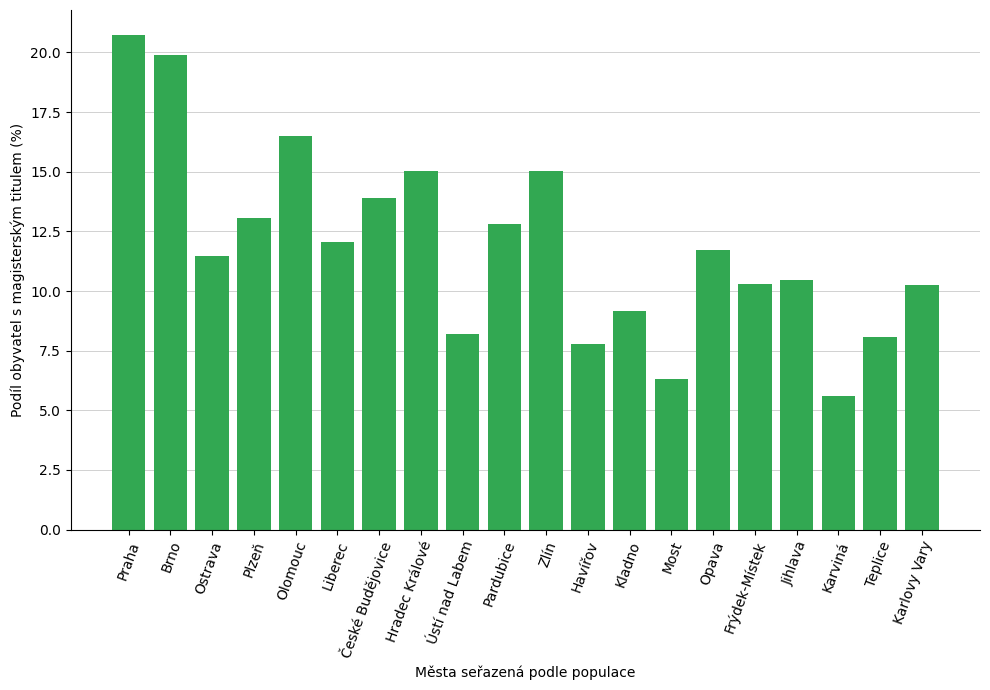

In [35]:
top_20_mest_pocet = {
    "Praha": 1301432,
    "Brno": 398510,
    "Ostrava": 282450,
    "Plzeň": 174007,
    "Olomouc": 106063,
    "Liberec": 104340,
    "České Budějovice": 95664,
    "Hradec Králové": 92649,
    "Ústí nad Labem": 89713,
    "Pardubice": 89619,
    "Zlín": 74178,
    "Havířov": 68153,
    "Kladno": 67756,
    "Most": 61306,
    "Opava": 55146,
    "Frýdek-Místek": 53698,
    "Jihlava": 50523,
    "Karviná": 48473,
    "Teplice": 48428,
    "Karlovy Vary": 44323
}

top_20_mest_mgr = {
    "Praha": 269964,
    "Brno": 79219,
    "Ostrava": 32435,
    "Plzeň": 22729,
    "Olomouc": 17487,
    "Liberec": 12599,
    "České Budějovice": 13315,
    "Hradec Králové": 13930,
    "Ústí nad Labem": 7357,
    "Pardubice": 11480,
    "Zlín": 11137,
    "Havířov": 5313,
    "Kladno": 6212,
    "Most": 3881,
    "Opava": 6458,
    "Frýdek-Místek": 5517,
    "Jihlava": 5296,
    "Karviná": 2708,
    "Teplice": 3901,
    "Karlovy Vary": 4551
}

# Vytvoření DataFrame
df_pocet = pd.DataFrame(list(top_20_mest_pocet.items()), columns=['Město', 'Počet'])
df_mgr = pd.DataFrame(list(top_20_mest_mgr.items()), columns=['Město', 'Mgr'])

# Sloučení DataFrame podle města
df = pd.merge(df_pocet, df_mgr, on='Město')

# Výpočet podílu obyvatel s magisterským titulem
df['Podíl Mgr'] = (df['Mgr'] / df['Počet']) * 100

# Vykreslení sloupcového grafu
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.bar(df['Město'], df['Podíl Mgr'], color='#32a852')

# Přidání popisků a titulku
ax.set_xlabel('Města seřazená podle populace')
ax.set_ylabel('Podíl obyvatel s magisterským titulem (%)')
# ax.set_title('Podíl obyvatel s magisterským titulem (Mgr) v top 20 městech ČR')
ax.set_xticklabels(df['Město'], rotation=70, ha='right', rotation_mode='anchor')

# Přidání horizontálních mřížkových čar
ax.grid(axis='y', linestyle='-', color='grey', linewidth=0.5, alpha=0.5)
ax.set_axisbelow(True)  # Nastavení mřížky na pozadí

# Odstranění ohraničení grafu
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Zobrazení grafu
plt.tight_layout()
plt.show()